# EmotiBit Sensor Data Visualizer

This Jupyter Notebook is designed to load, process, and visualize sensor data from an EmotiBit device. It generates individual plots for each specified signal channel and overlays them with annotations for music playback periods.

**Features:**
1.  **Automatic Dependency Installation**: Installs required Python packages automatically.
2.  **Automatic Data Loading**: Reads all EmotiBit CSV files from a specified folder.
3.  **Time Conversion**: Converts the `LocalTimestamp` (Unix epoch) to Eastern Standard Time (EST) for the x-axis.
4.  **Multi-Plot Generation**: Creates a separate, clean plot for each signal type defined in the configuration.
5.  **Intelligent Music Annotation**: Reads an Excel schedule, correctly identifies the music session's start and end, and creates annotations for each time point.
6.  **Save to File**: Automatically saves each generated plot as a PNG image to a specified output folder.

## 1. Setup and Dependencies

This cell will install the necessary Python libraries (`pandas`, `matplotlib`, `openpyxl`) for this notebook to function correctly.

In [16]:
import sys
!{sys.executable} -m pip install pandas matplotlib openpyxl
print("Required packages are installed.")

Required packages are installed.


## 2. Configuration

Modify the data folder path, music schedule file path, and the list of signals you wish to plot. Ensure the paths are correct.

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import glob
import textwrap

# --- User Configuration --- #

# 1. Set the path to the specific data folder you want to process.
DATA_FOLDER_PATH = '../PwD dataset/July 22 Morning ER 000439' # <-- CHANGE THIS FOLDER

# 2. Define paths for the schedule and output plots relative to the data folder.
MUSIC_SCHEDULE_PATH = os.path.join(DATA_FOLDER_PATH, 'music.xlsx')
OUTPUT_FOLDER = os.path.join(DATA_FOLDER_PATH, 'plots')

# 3. Channels to plot and their descriptions.
CHANNELS = {
    'AX': 'Accelerometer X', 'AY': 'Accelerometer Y', 'AZ': 'Accelerometer Z',
    'GX': 'Gyroscope X', 'GY': 'Gyroscope Y', 'GZ': 'Gyroscope Z',
    'EA': 'Electrodermal Activity', 'EL': 'Electrodermal Level',
    'SF': 'SCR Frequency', 'SA': 'SCR Amplitude', 'SR': 'SCR Rise Time',
    'T1': 'Temperature', 'TH': 'Thermopile Temperature',
    'PI': 'PPG Infrared', 'PR': 'PPG Red', 'PG': 'PPG Green',
    'BI': 'Beat Interval', 'HR': 'Heart Rate',
}
SIGNALS_TO_PLOT = list(CHANNELS.keys())

# 4. Plot styling settings
FIGURE_SIZE = (22, 7)
ANNOTATION_BACKGROUND_COLOR = 'grey'
ANNOTATION_ALPHA = 0.2

## 3. Data Loading and Preprocessing

These functions load the EmotiBit sensor data and the event schedule from your files.
At the end of this cell, the data loading process is executed.

In [27]:
def load_emotibit_data(folder_path, signals_to_plot):
    """Loads and processes EmotiBit CSV files from a specified folder."""
    print(f"--- Starting EmotiBit Data Loading from '{folder_path}' ---")
    dataframes = {}
    experiment_date_str = None
    try:
        all_files = glob.glob(os.path.join(folder_path, '*.csv'))
        if not all_files:
            print(f"Error: No CSV files found in '{folder_path}'. Please check the path.")
            return {}, None
    except Exception as e:
        print(f"Error: Could not access folder '{folder_path}'. {e}")
        return {}, None

    for file_path in all_files:
        basename = os.path.basename(file_path)
        try:
            date_part = basename.split('_')[0]
            datetime.datetime.strptime(date_part, '%Y-%m-%d')
            experiment_date_str = date_part.replace('-', '')
            print(f"Successfully extracted experiment date: {experiment_date_str} from filename '{basename}'")
            break
        except (ValueError, IndexError):
            continue
    if not experiment_date_str:
        print("Error: Could not parse experiment date from any filename.")
        return {}, None

    for signal_type in signals_to_plot:
        file_pattern = os.path.join(folder_path, f"*_{signal_type}.csv")
        found_files = glob.glob(file_pattern)
        if not found_files:
            continue
        file_path = found_files[0]
        print(f"  - Reading file: {os.path.basename(file_path)}")
        
        try:
            df = pd.read_csv(file_path)
            if 'LocalTimestamp' not in df.columns or df.shape[1] < 2:
                continue
            signal_column_name = df.columns[-1]
            df['est_time'] = pd.to_datetime(df['LocalTimestamp'], unit='s').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
            df.rename(columns={signal_column_name: 'value'}, inplace=True)
            dataframes[signal_type] = df[['est_time', 'value']]
        except Exception as e:
            print(f"  - Error processing file '{os.path.basename(file_path)}': {e}")
    print(f"--- EmotiBit Data Loading Complete. Loaded {len(dataframes)} signals. ---\n")
    return dataframes, experiment_date_str

def load_music_schedule(file_path, experiment_date_str, data_folder_path):
    """Loads the schedule and prepares annotations for each time point."""
    print(f"--- Starting Schedule Loading from '{file_path}' ---")
    if not os.path.exists(file_path):
        print(f"Info: Schedule file not found. Plots will not have annotations.")
        return None
    try:
        df_schedule = pd.read_excel(file_path, header=0, usecols=[0, 1, 2], names=['time_str', 'song_artist', 'observation'])
        df_schedule.dropna(how='all', inplace=True)
        if df_schedule.empty:
            return None
    except Exception as e:
        print(f"Error: Failed to read schedule Excel file: {e}")
        return None

    is_afternoon = 'afternoon' in data_folder_path.lower()
    time_period = "PM" if is_afternoon else "AM"
    if is_afternoon:
        print("  - 'Afternoon' detected in data path. Times will be treated as PM.")
    else:
        print("  - 'Morning' or no specifier detected. Times will be treated as AM.")

    annotations = []
    first_song_start_time = None
    final_end_time = None

    def parse_time(time_str, date_str, is_pm):
        time_obj = datetime.datetime.strptime(time_str, '%H:%M:%S').time() if ':' in time_str[2:] else datetime.datetime.strptime(time_str, '%H:%M').time()
        hour = time_obj.hour
        if is_pm and 1 <= hour <= 11:
            hour += 12
        full_datetime_str = f"{date_str} {hour:02d}:{time_obj.minute:02d}:{time_obj.second:02d}"
        dt_naive = datetime.datetime.strptime(full_datetime_str, '%Y%m%d %H:%M:%S')
        return pd.Timestamp(dt_naive, tz='US/Eastern')

    all_events = []
    for index, row in df_schedule.iterrows():
        try:
            current_row_time = parse_time(str(row['time_str']).strip(), experiment_date_str, is_afternoon)
            song_artist = str(row['song_artist']).strip() if pd.notna(row['song_artist']) else '–'
            observation = str(row['observation']).strip() if pd.notna(row['observation']) else ''
            all_events.append({'time': current_row_time, 'song': song_artist, 'obs': observation})
        except (ValueError, TypeError) as e:
            print(f"Warning: Could not parse time '{row['time_str']}' on Excel row {index+2}. Skipping. Error: {e}")
            continue
    
    if not all_events:
        return None

    for event in all_events:
        if event['song'] != '–':
            first_song_start_time = event['time']
            print(f"  - Music session starts at: {first_song_start_time.strftime('%H:%M:%S')}")
            break

    final_end_time = all_events[-1]['time']
    print(f"  - Music session ends at: {final_end_time.strftime('%H:%M:%S')}")

    for event in all_events:
        combined_text = f"{event['song']}\n{event['obs']}".strip()
        annotations.append({'time': event['time'], 'text': combined_text})
        
        # This is the new, more detailed printout
        print(f"  - Created Annotation at: {event['time'].strftime('%H:%M:%S')}")
        print(f"    - Column 2 (Song): {event['song']}")
        print(f"    - Column 3 (Obs.): {event['obs']}")

        
    print(f"--- Schedule Loading Complete. Processed {len(annotations)} annotations. ---\n")
    return {'annotations': annotations, 'music_start': first_song_start_time, 'music_end': final_end_time}

# --- Execute Data Loading --- #
print("--- Section 1: Setup Complete ---")
print(f"Data folder set to: {DATA_FOLDER_PATH}")
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
print(f"Output folder set to: {OUTPUT_FOLDER}\n")

emotibit_data_path = DATA_FOLDER_PATH
emotibit_data, date_str = load_emotibit_data(emotibit_data_path, SIGNALS_TO_PLOT)

schedule_data = None
if date_str:
    schedule_data = load_music_schedule(MUSIC_SCHEDULE_PATH, date_str, DATA_FOLDER_PATH)

--- Section 1: Setup Complete ---
Data folder set to: ../PwD dataset/July 22 Morning ER 000439
Output folder set to: ../PwD dataset/July 22 Morning ER 000439/plots

--- Starting EmotiBit Data Loading from '../PwD dataset/July 22 Morning ER 000439' ---
Successfully extracted experiment date: 20250722 from filename '2025-07-22_10-43-20-236504_GZ.csv'
  - Reading file: 2025-07-22_10-43-20-236504_AX.csv
  - Reading file: 2025-07-22_10-43-20-236504_AY.csv
  - Reading file: 2025-07-22_10-43-20-236504_AZ.csv
  - Reading file: 2025-07-22_10-43-20-236504_GX.csv
  - Reading file: 2025-07-22_10-43-20-236504_GY.csv
  - Reading file: 2025-07-22_10-43-20-236504_GZ.csv
  - Reading file: 2025-07-22_10-43-20-236504_EA.csv
  - Reading file: 2025-07-22_10-43-20-236504_EL.csv
  - Reading file: 2025-07-22_10-43-20-236504_SF.csv
  - Reading file: 2025-07-22_10-43-20-236504_SA.csv
  - Reading file: 2025-07-22_10-43-20-236504_SR.csv
  - Reading file: 2025-07-22_10-43-20-236504_T1.csv
  - Reading file: 2025-07

## 4. Visualization and Saving Plots

This function generates and saves the plots for each signal. At the end of the cell, the plotting process is executed.


--- Generating and Saving 18 Plots ---


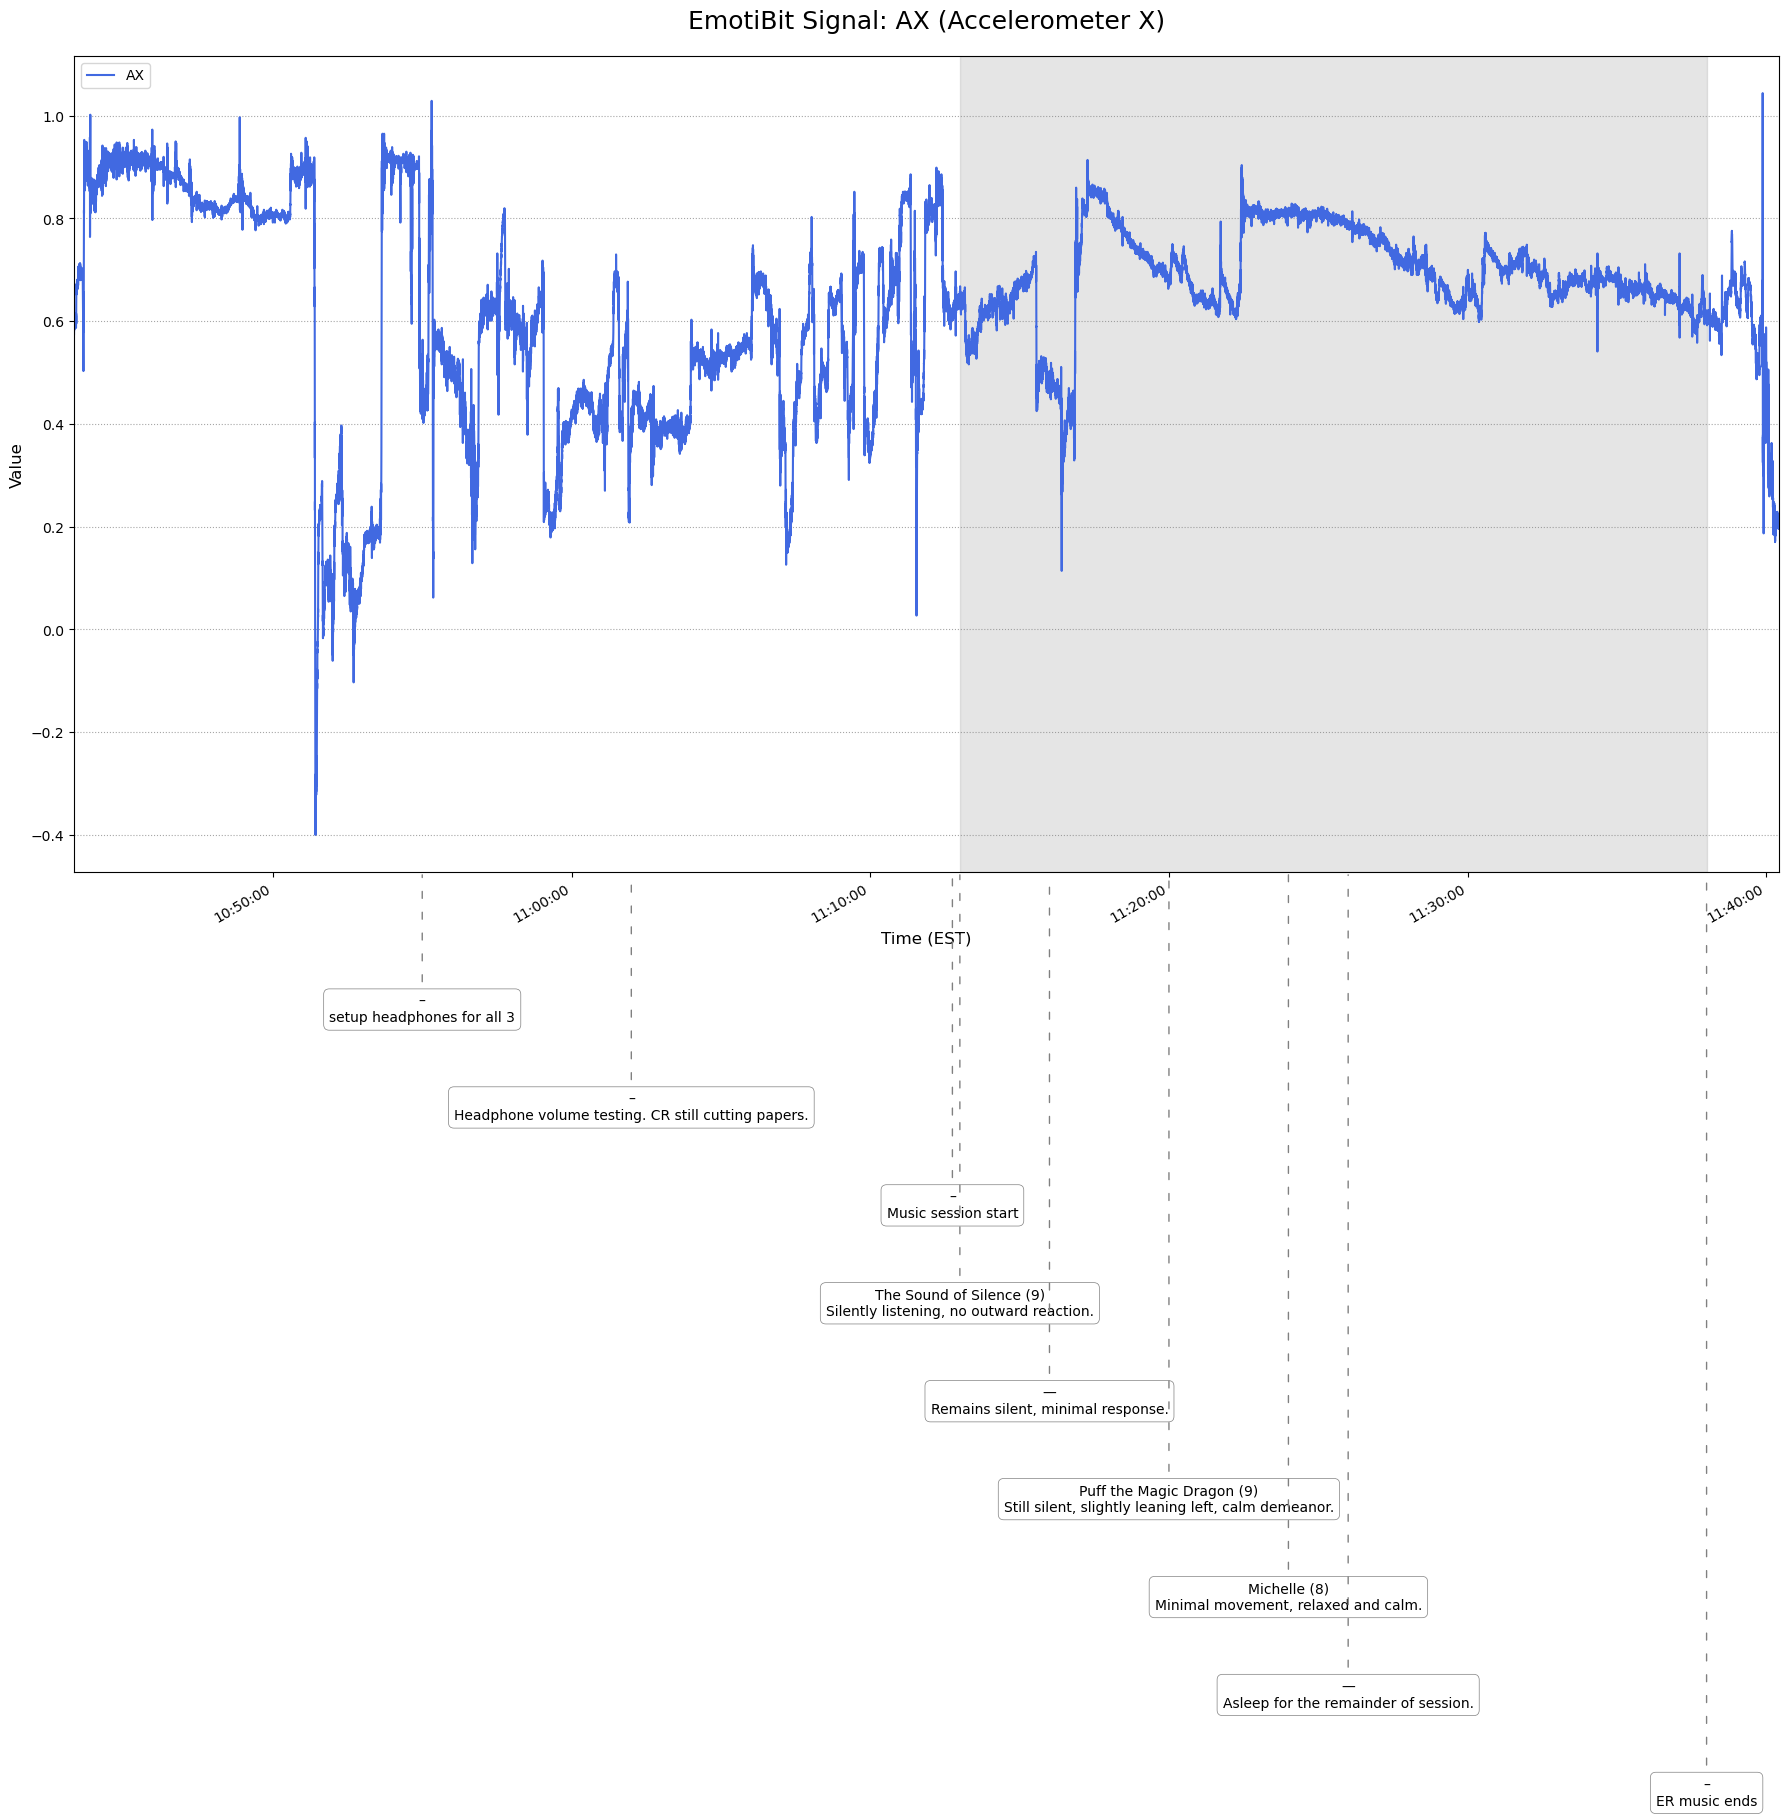

  - Plot saved to: ../PwD dataset/July 22 Morning ER 000439/plots/AX_plot.png


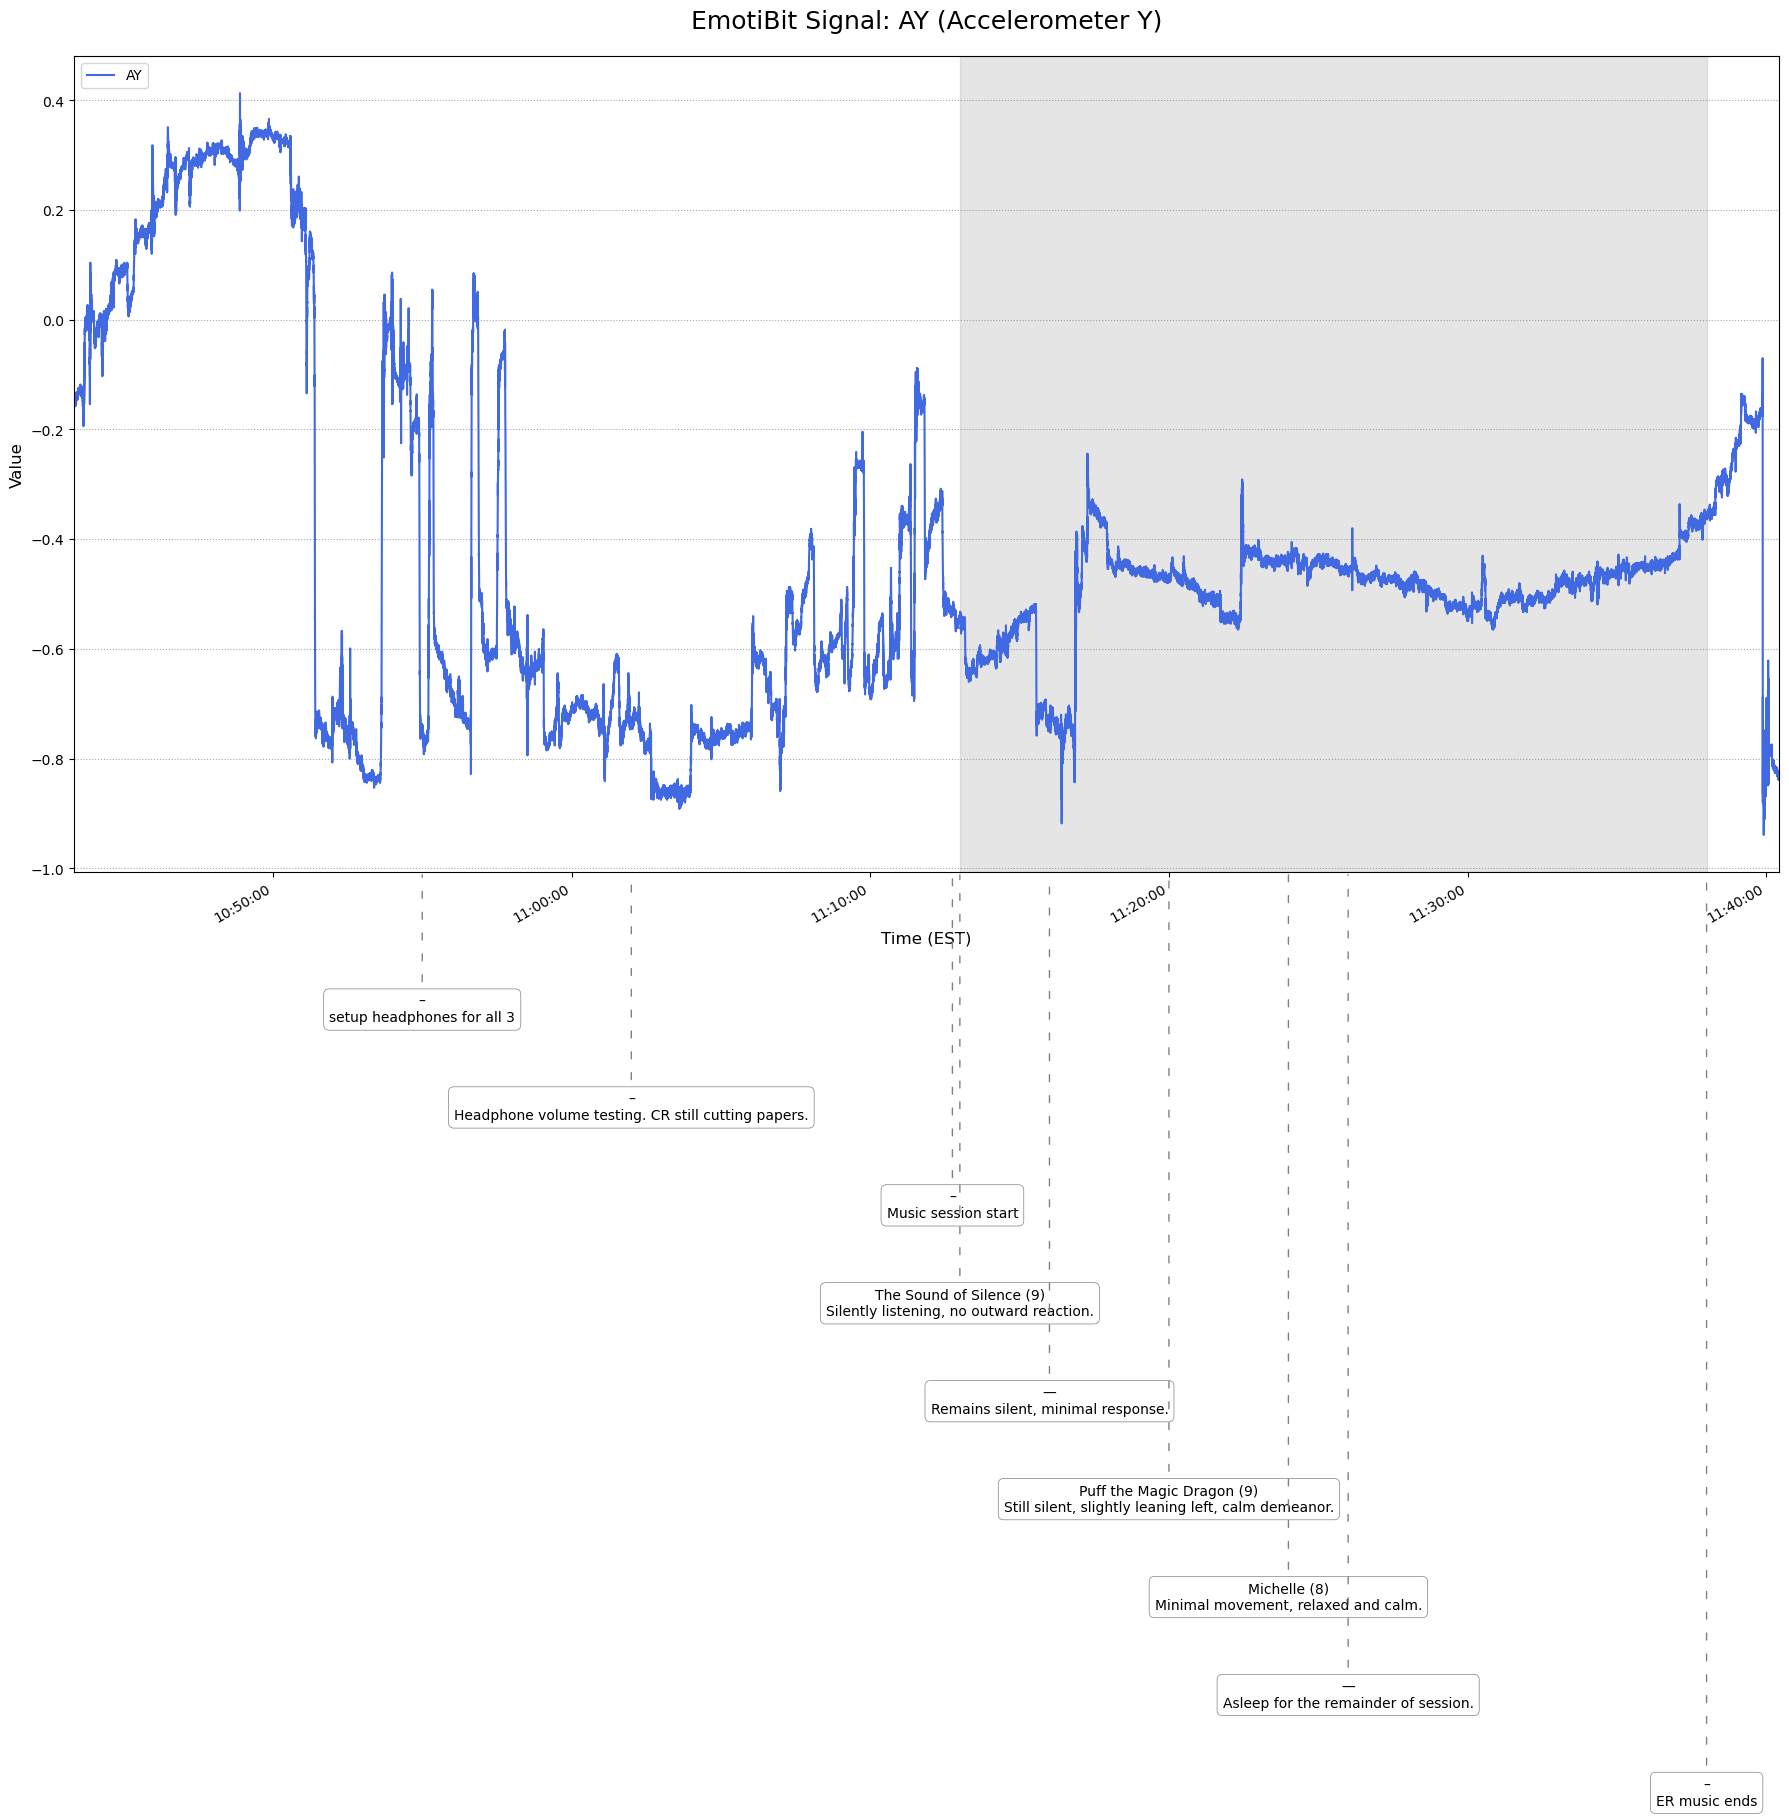

  - Plot saved to: ../PwD dataset/July 22 Morning ER 000439/plots/AY_plot.png


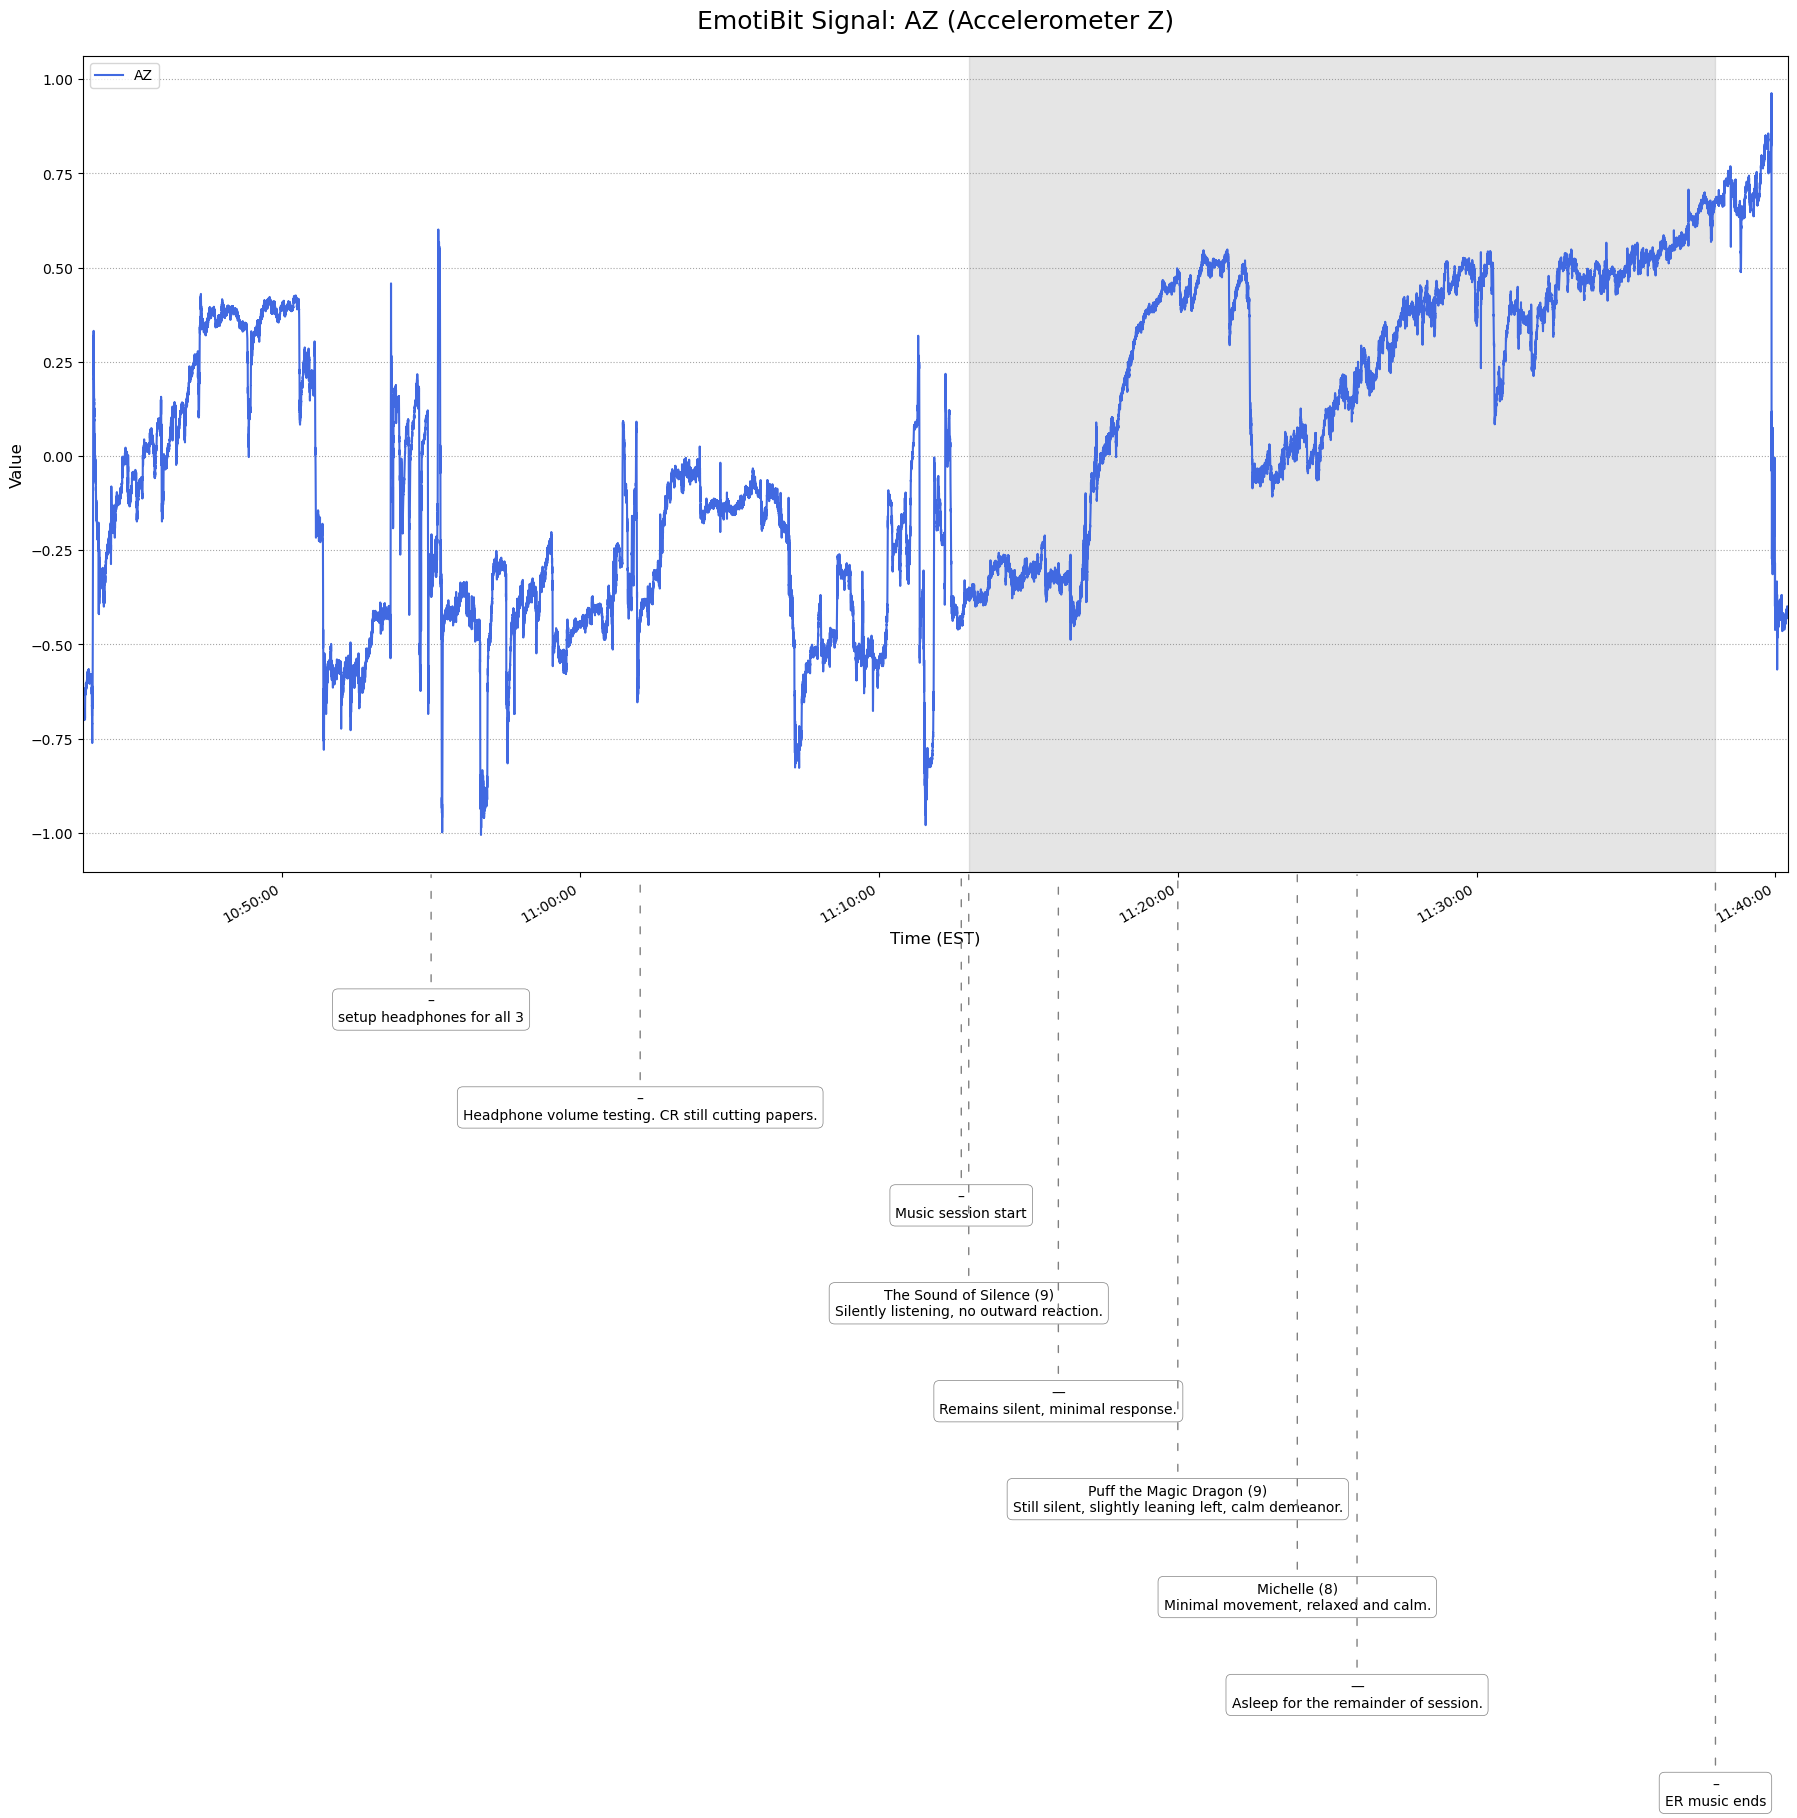

  - Plot saved to: ../PwD dataset/July 22 Morning ER 000439/plots/AZ_plot.png


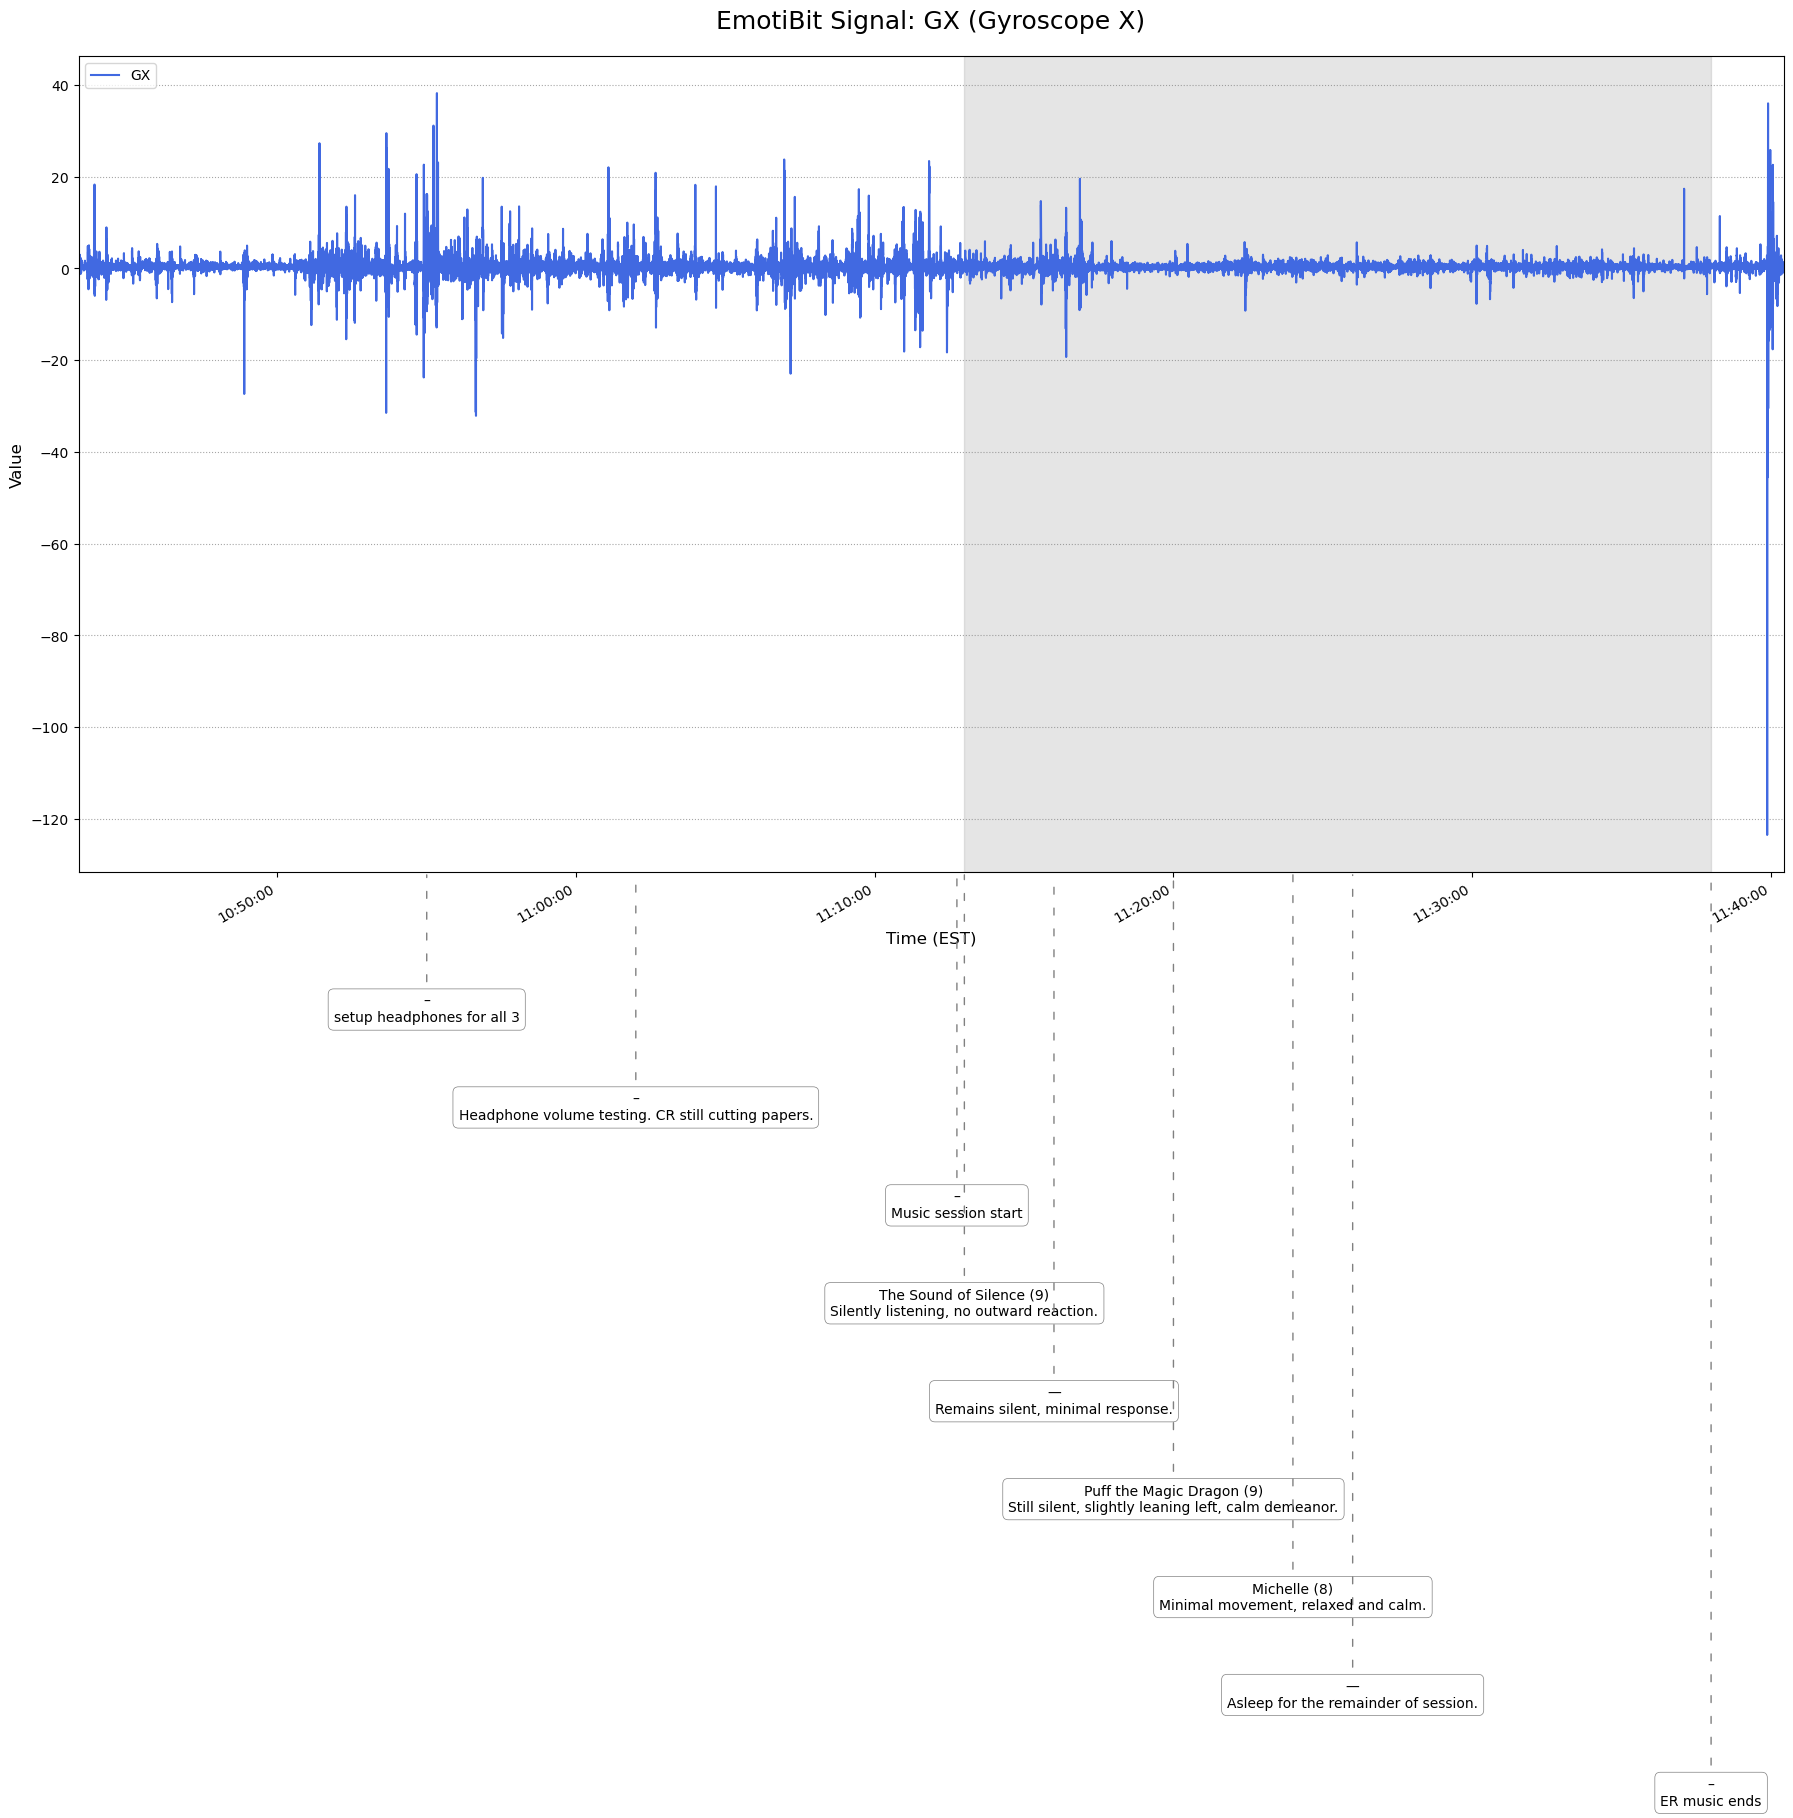

  - Plot saved to: ../PwD dataset/July 22 Morning ER 000439/plots/GX_plot.png


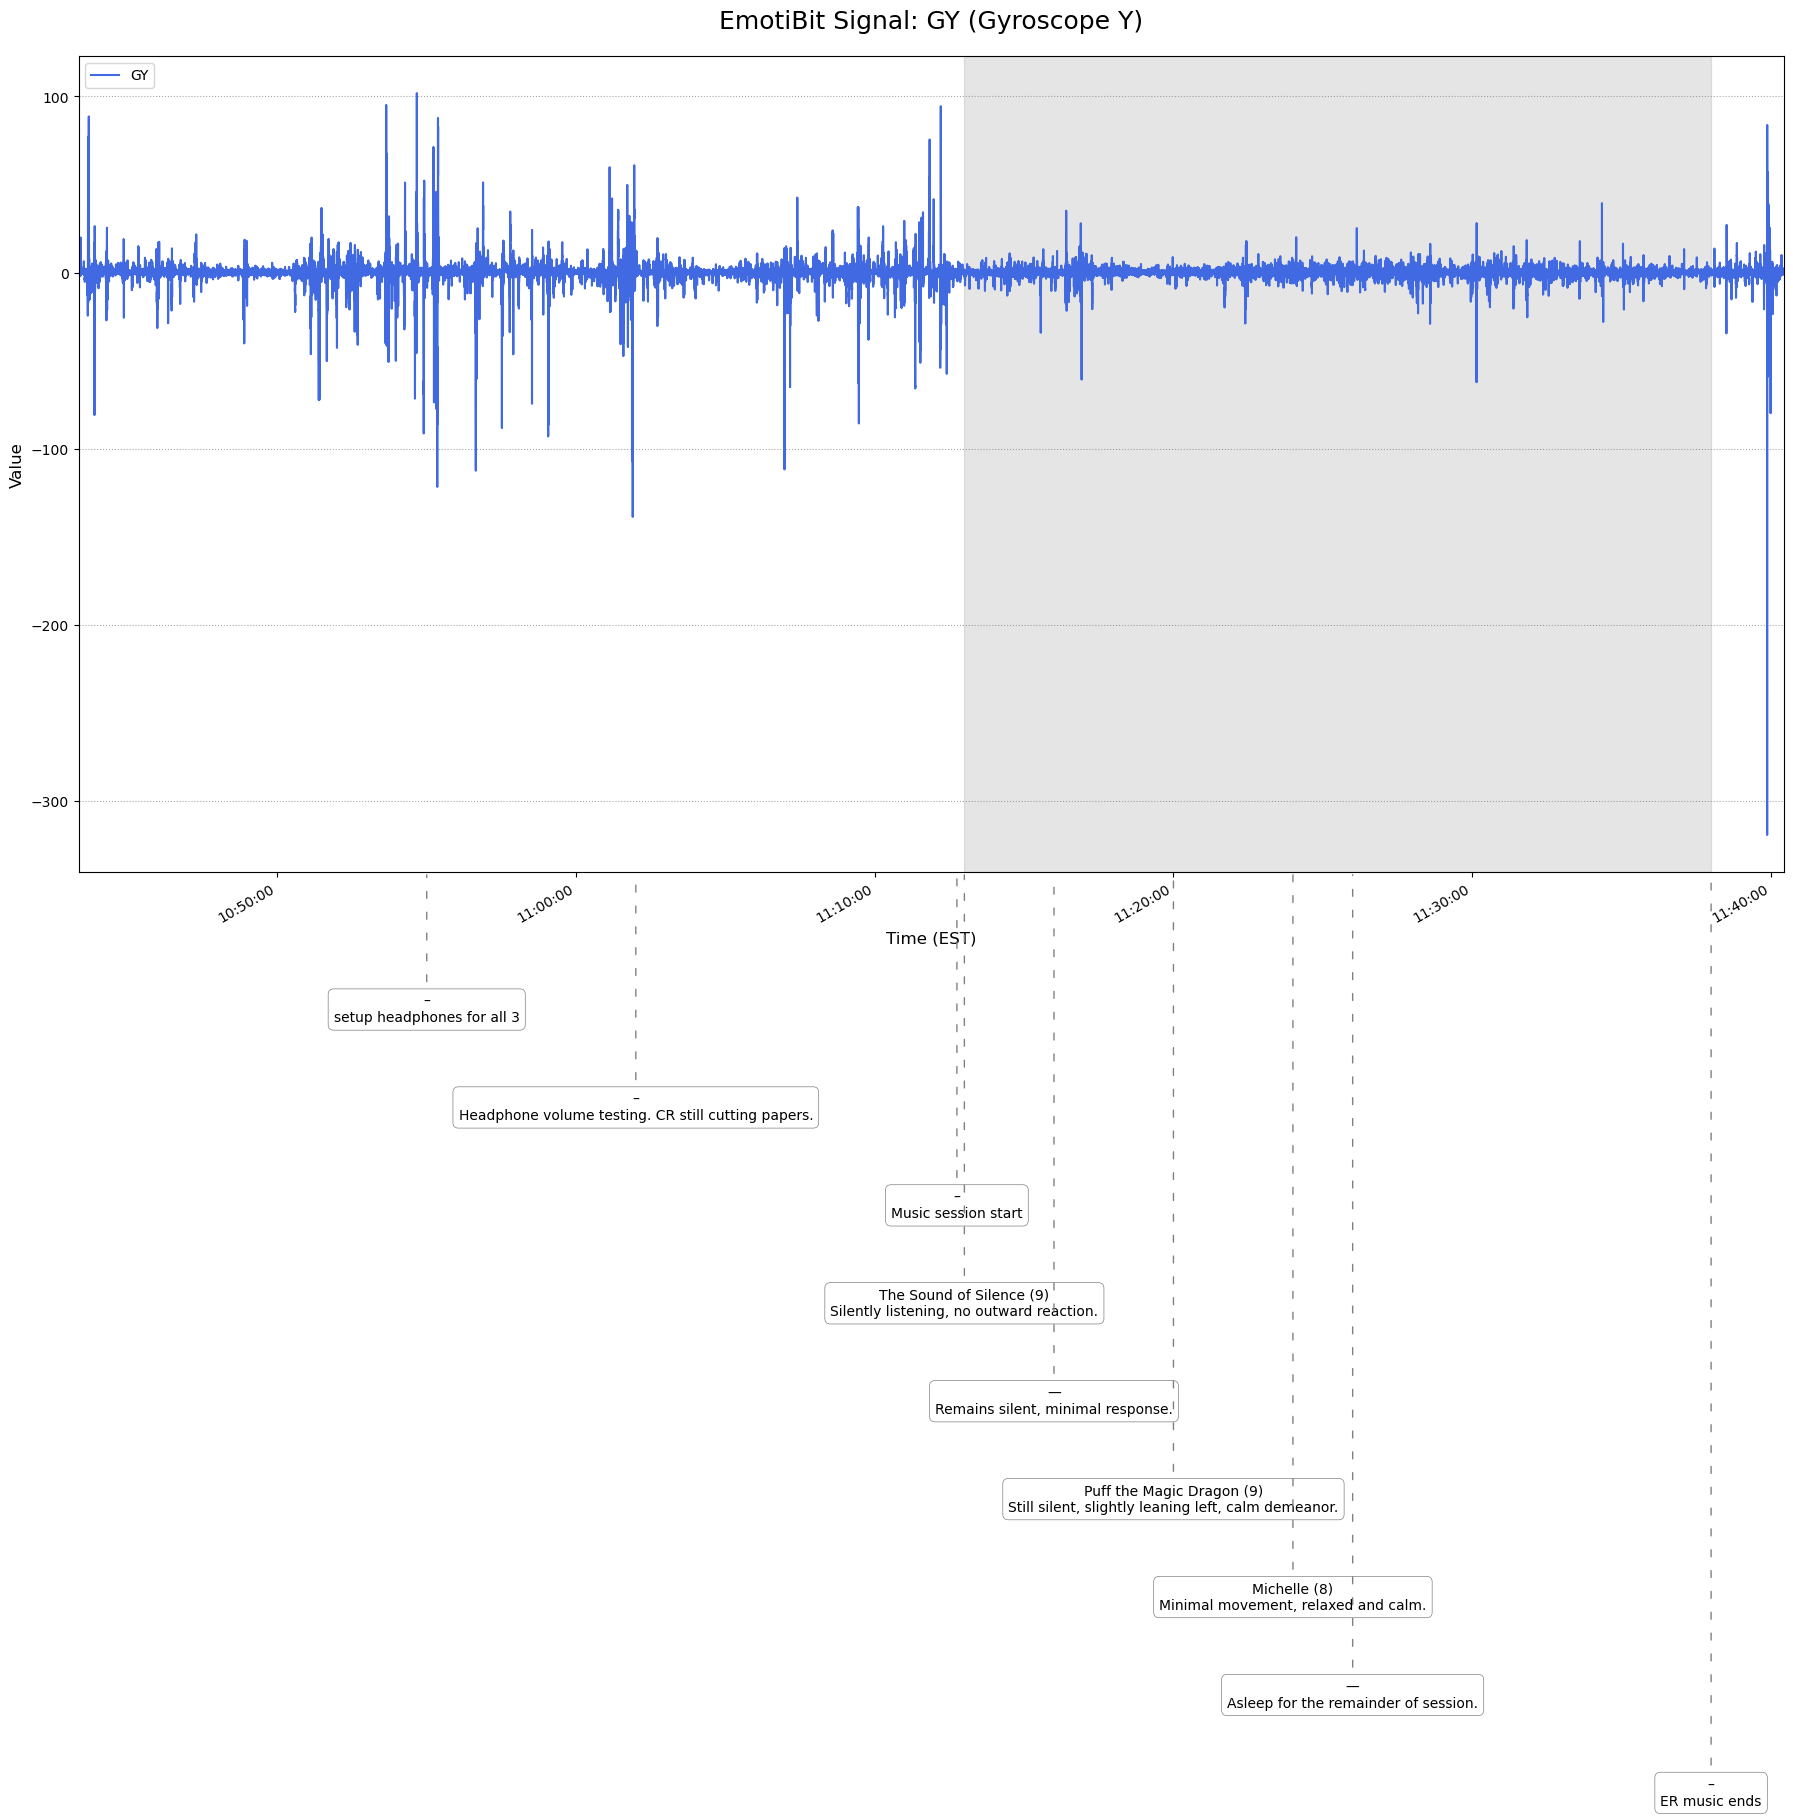

  - Plot saved to: ../PwD dataset/July 22 Morning ER 000439/plots/GY_plot.png


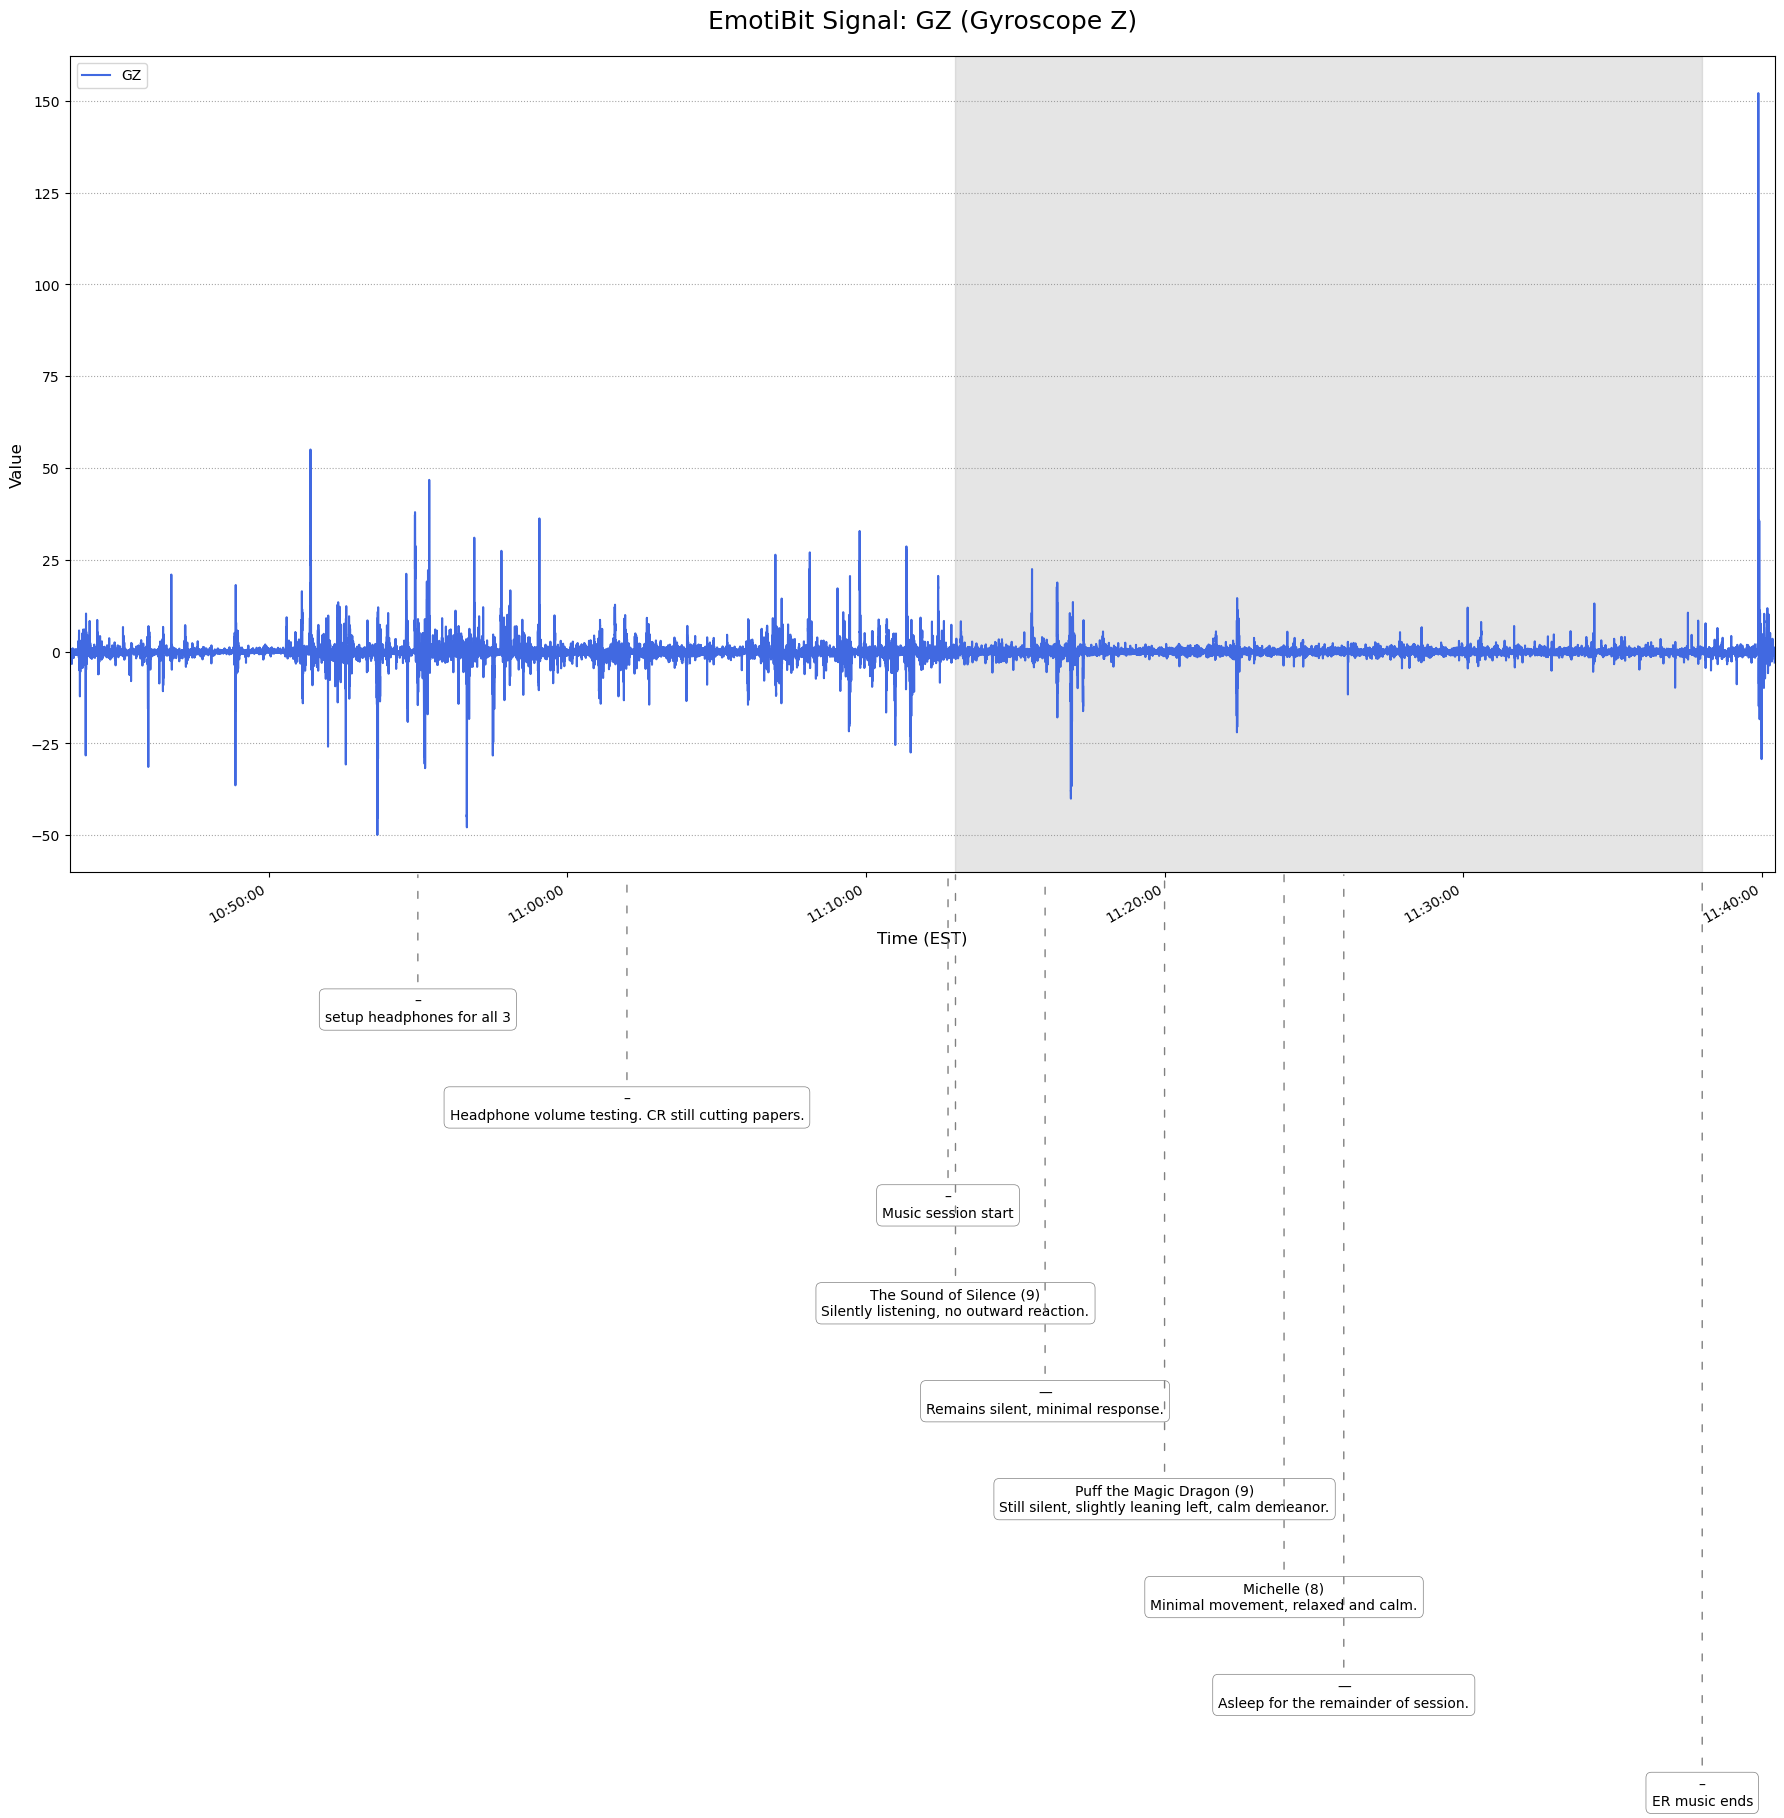

  - Plot saved to: ../PwD dataset/July 22 Morning ER 000439/plots/GZ_plot.png


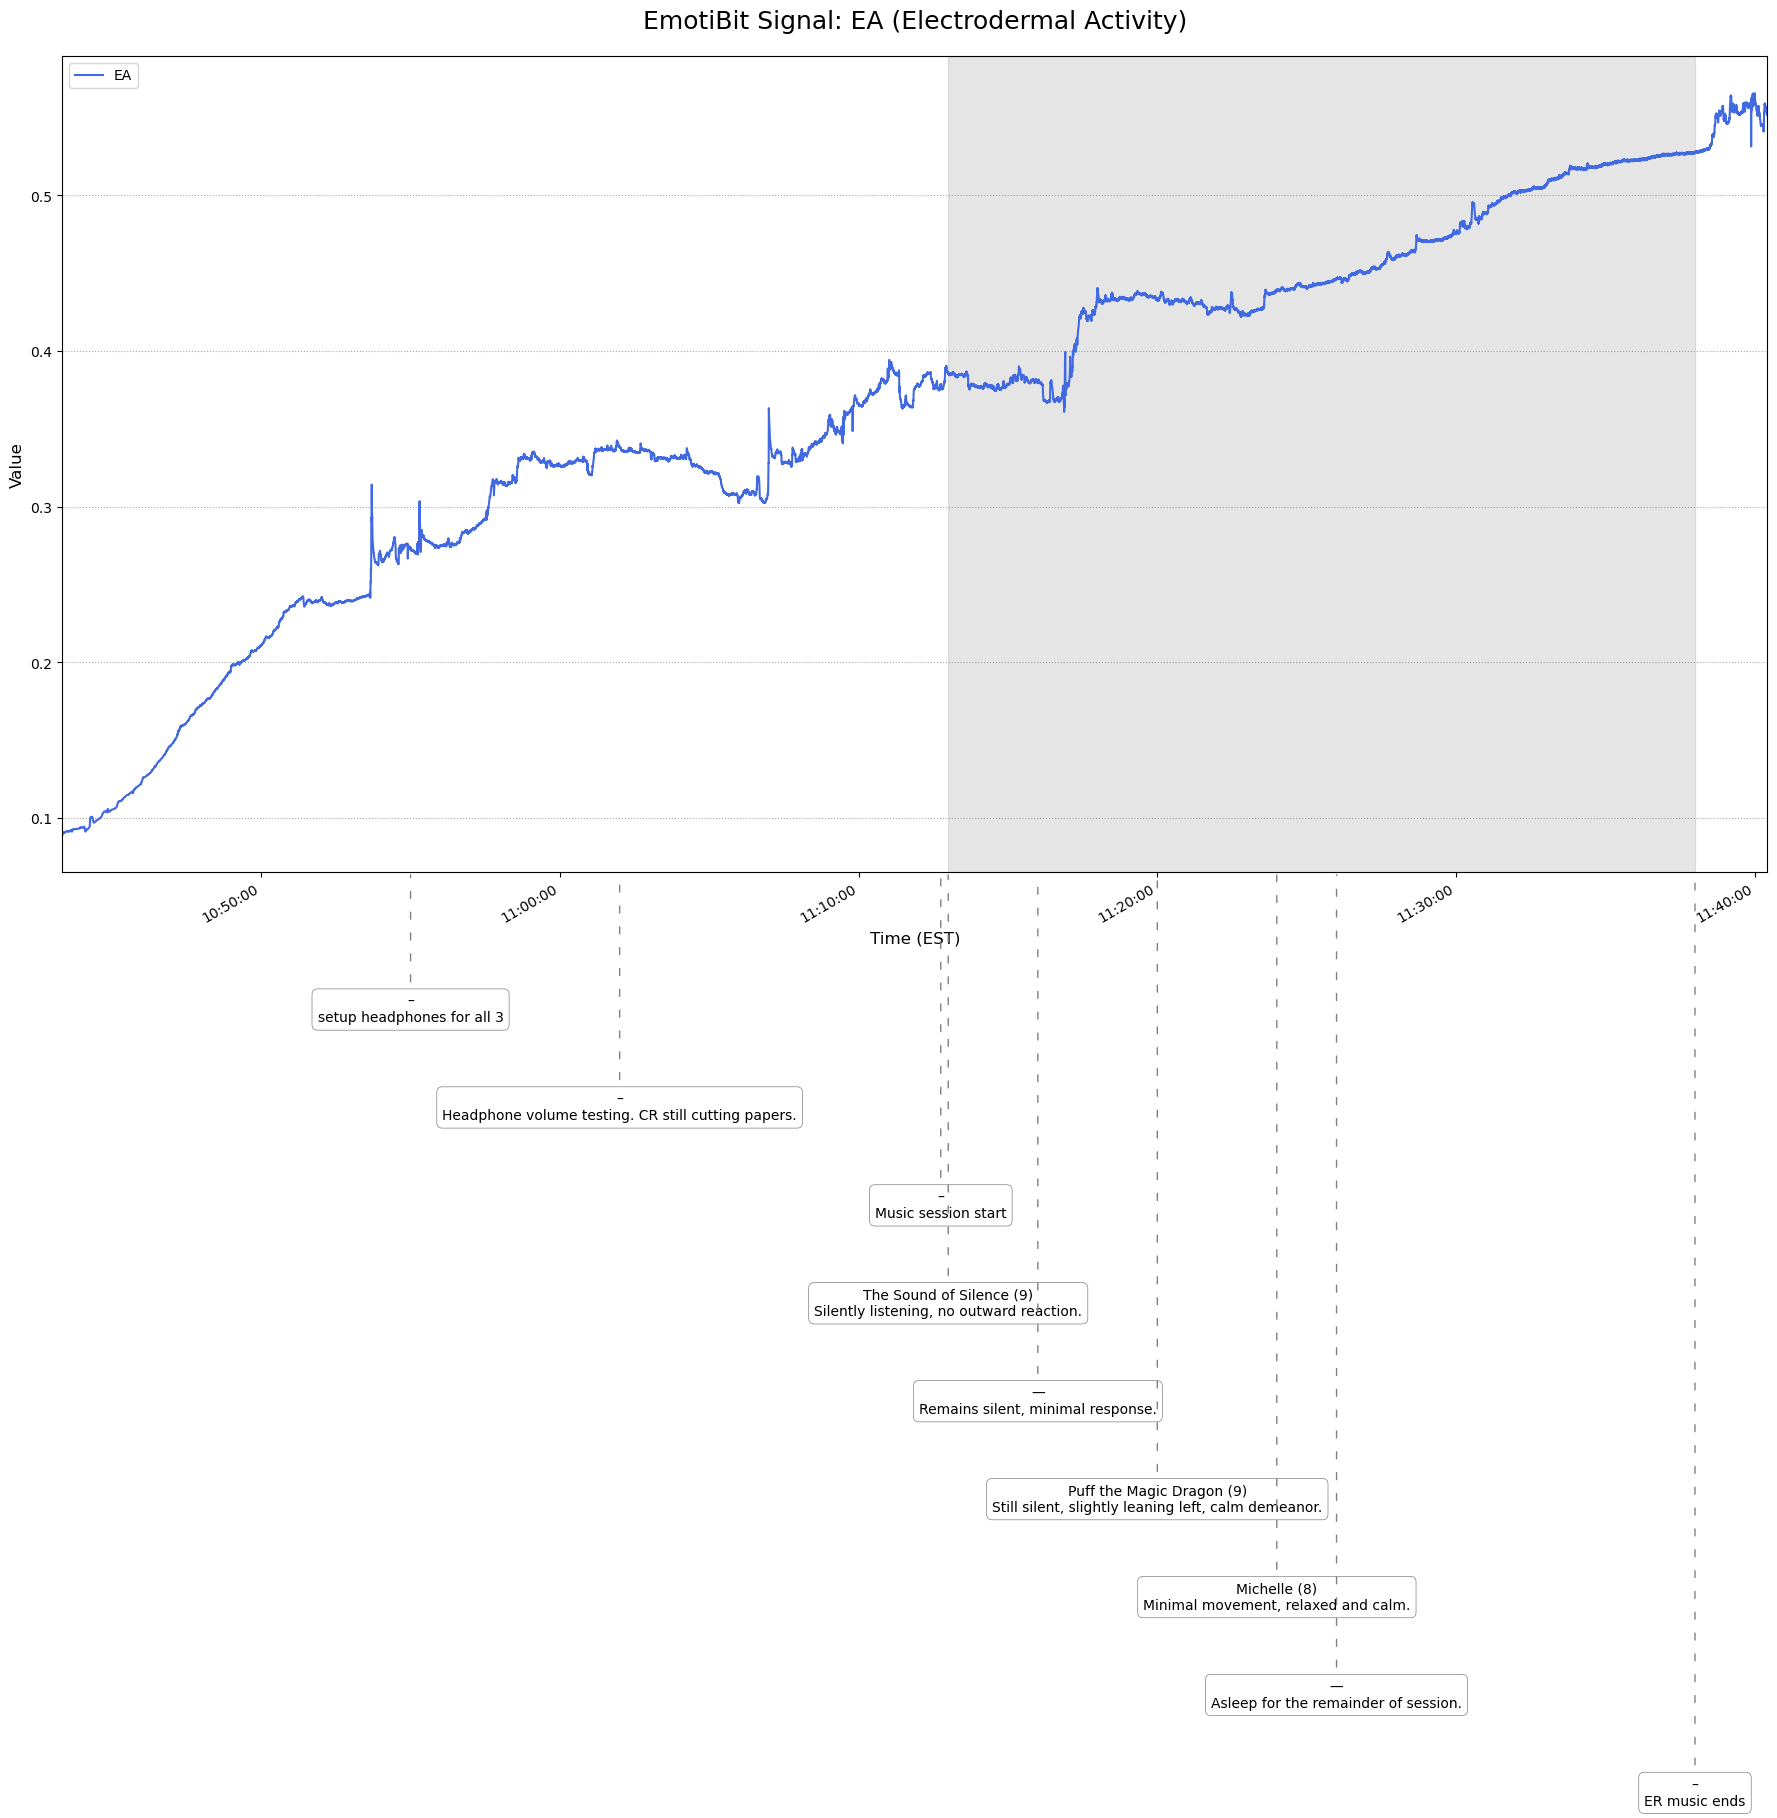

  - Plot saved to: ../PwD dataset/July 22 Morning ER 000439/plots/EA_plot.png


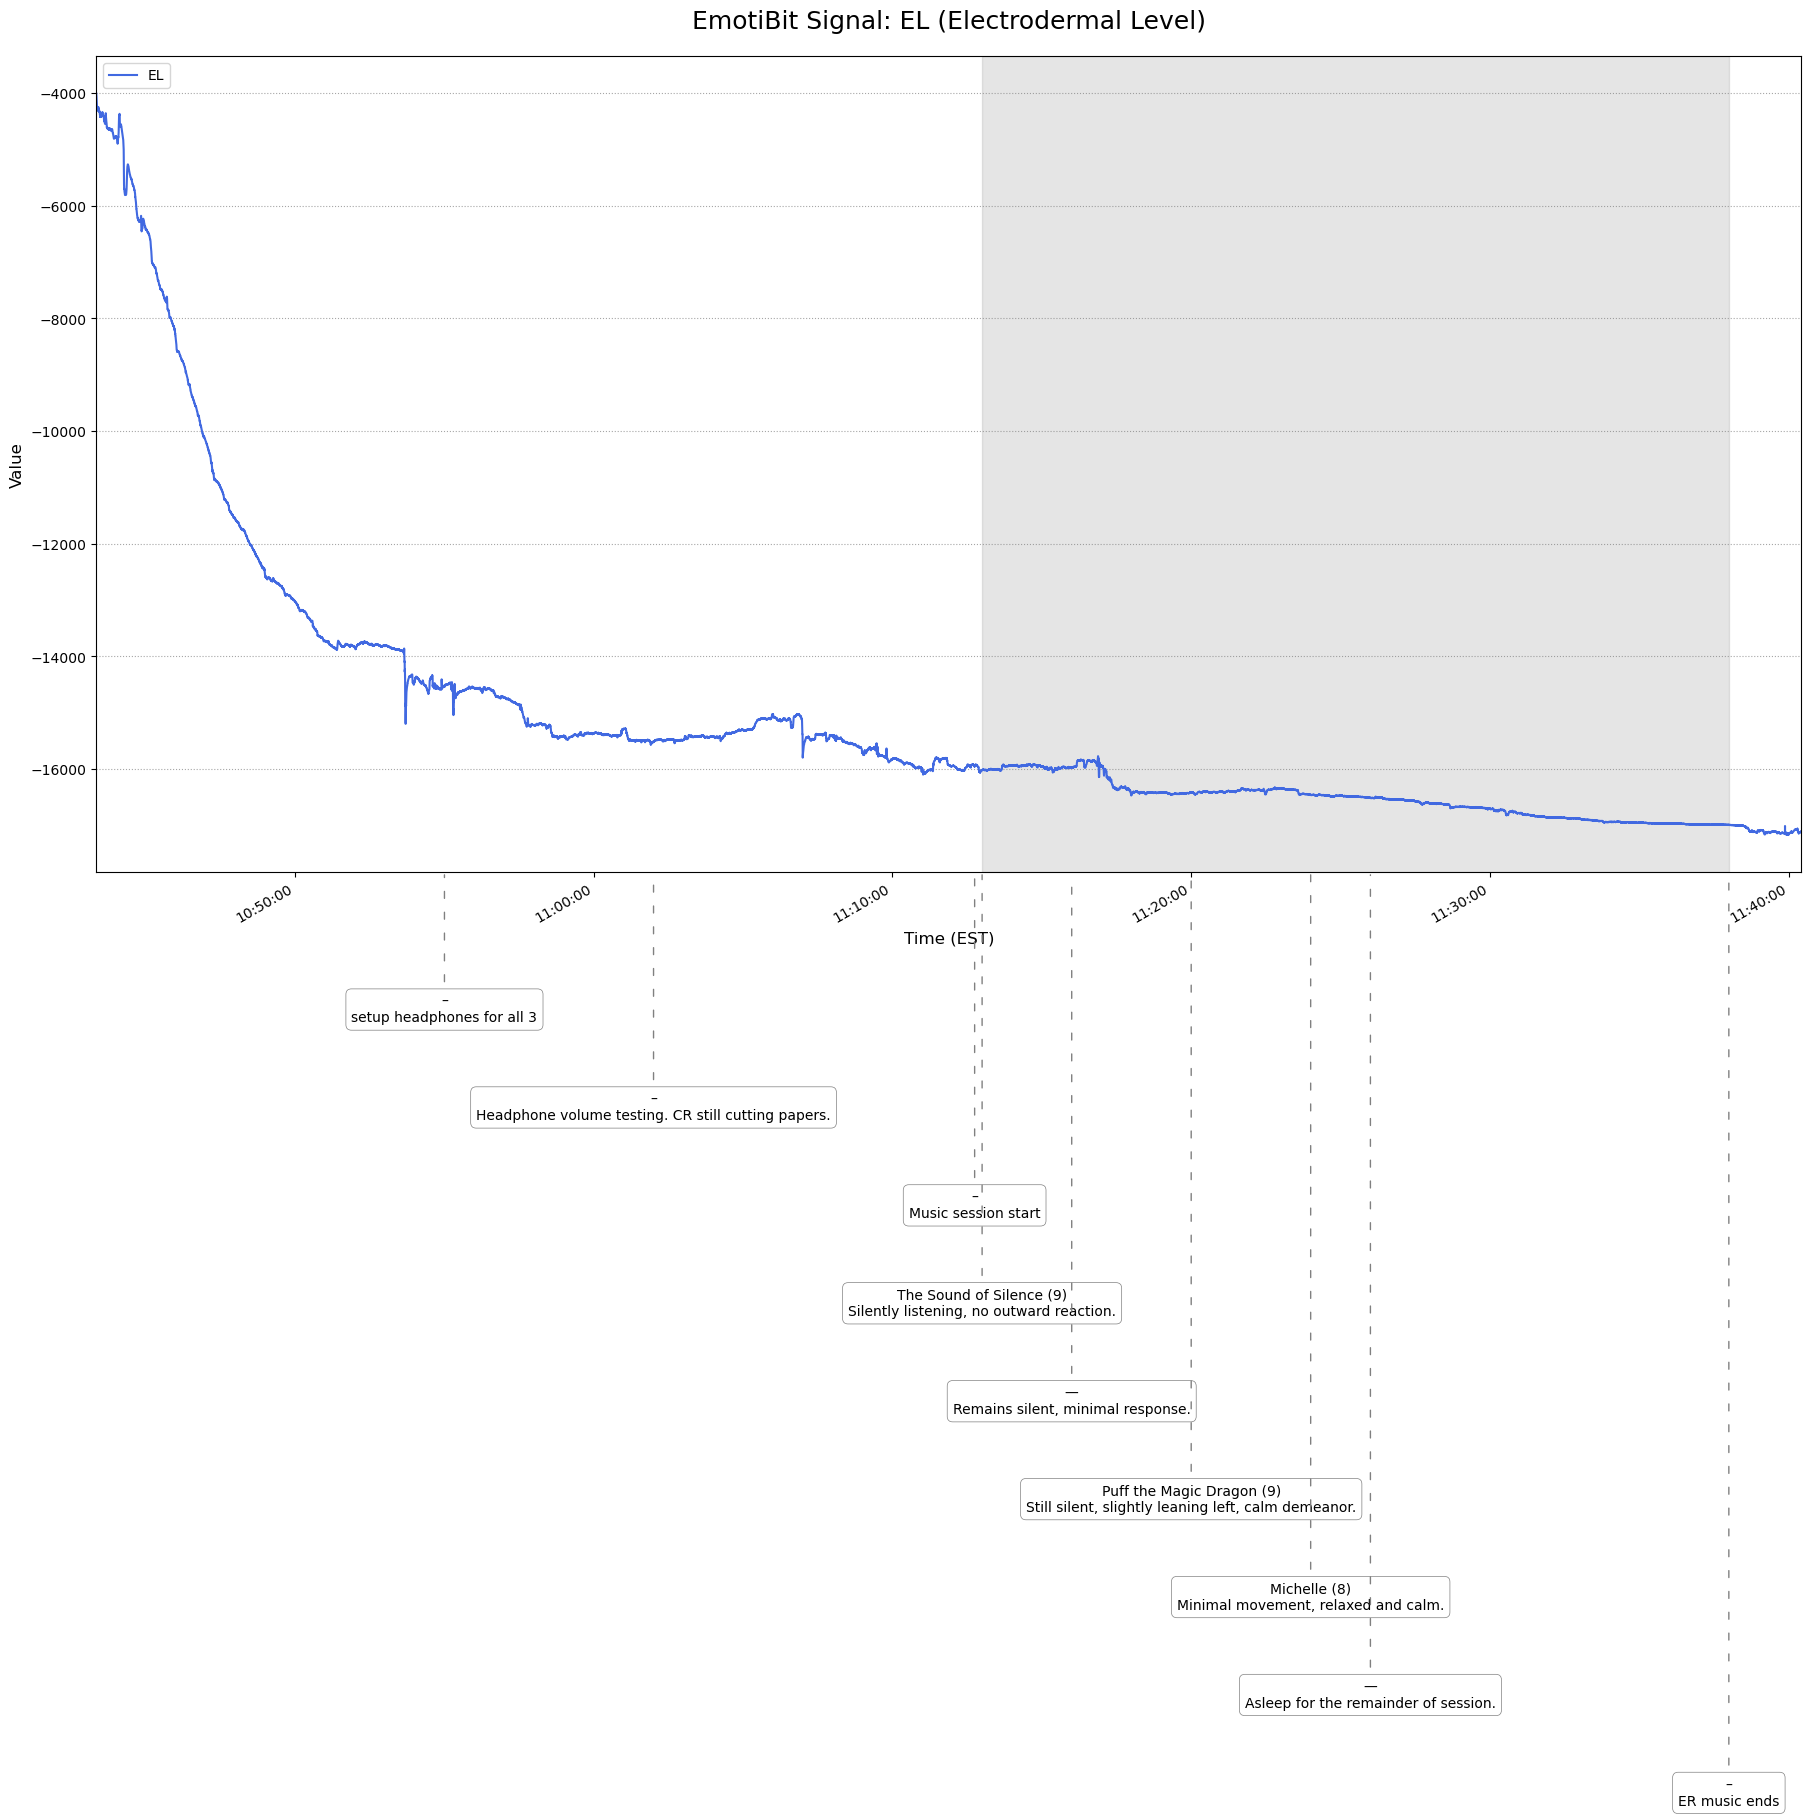

  - Plot saved to: ../PwD dataset/July 22 Morning ER 000439/plots/EL_plot.png


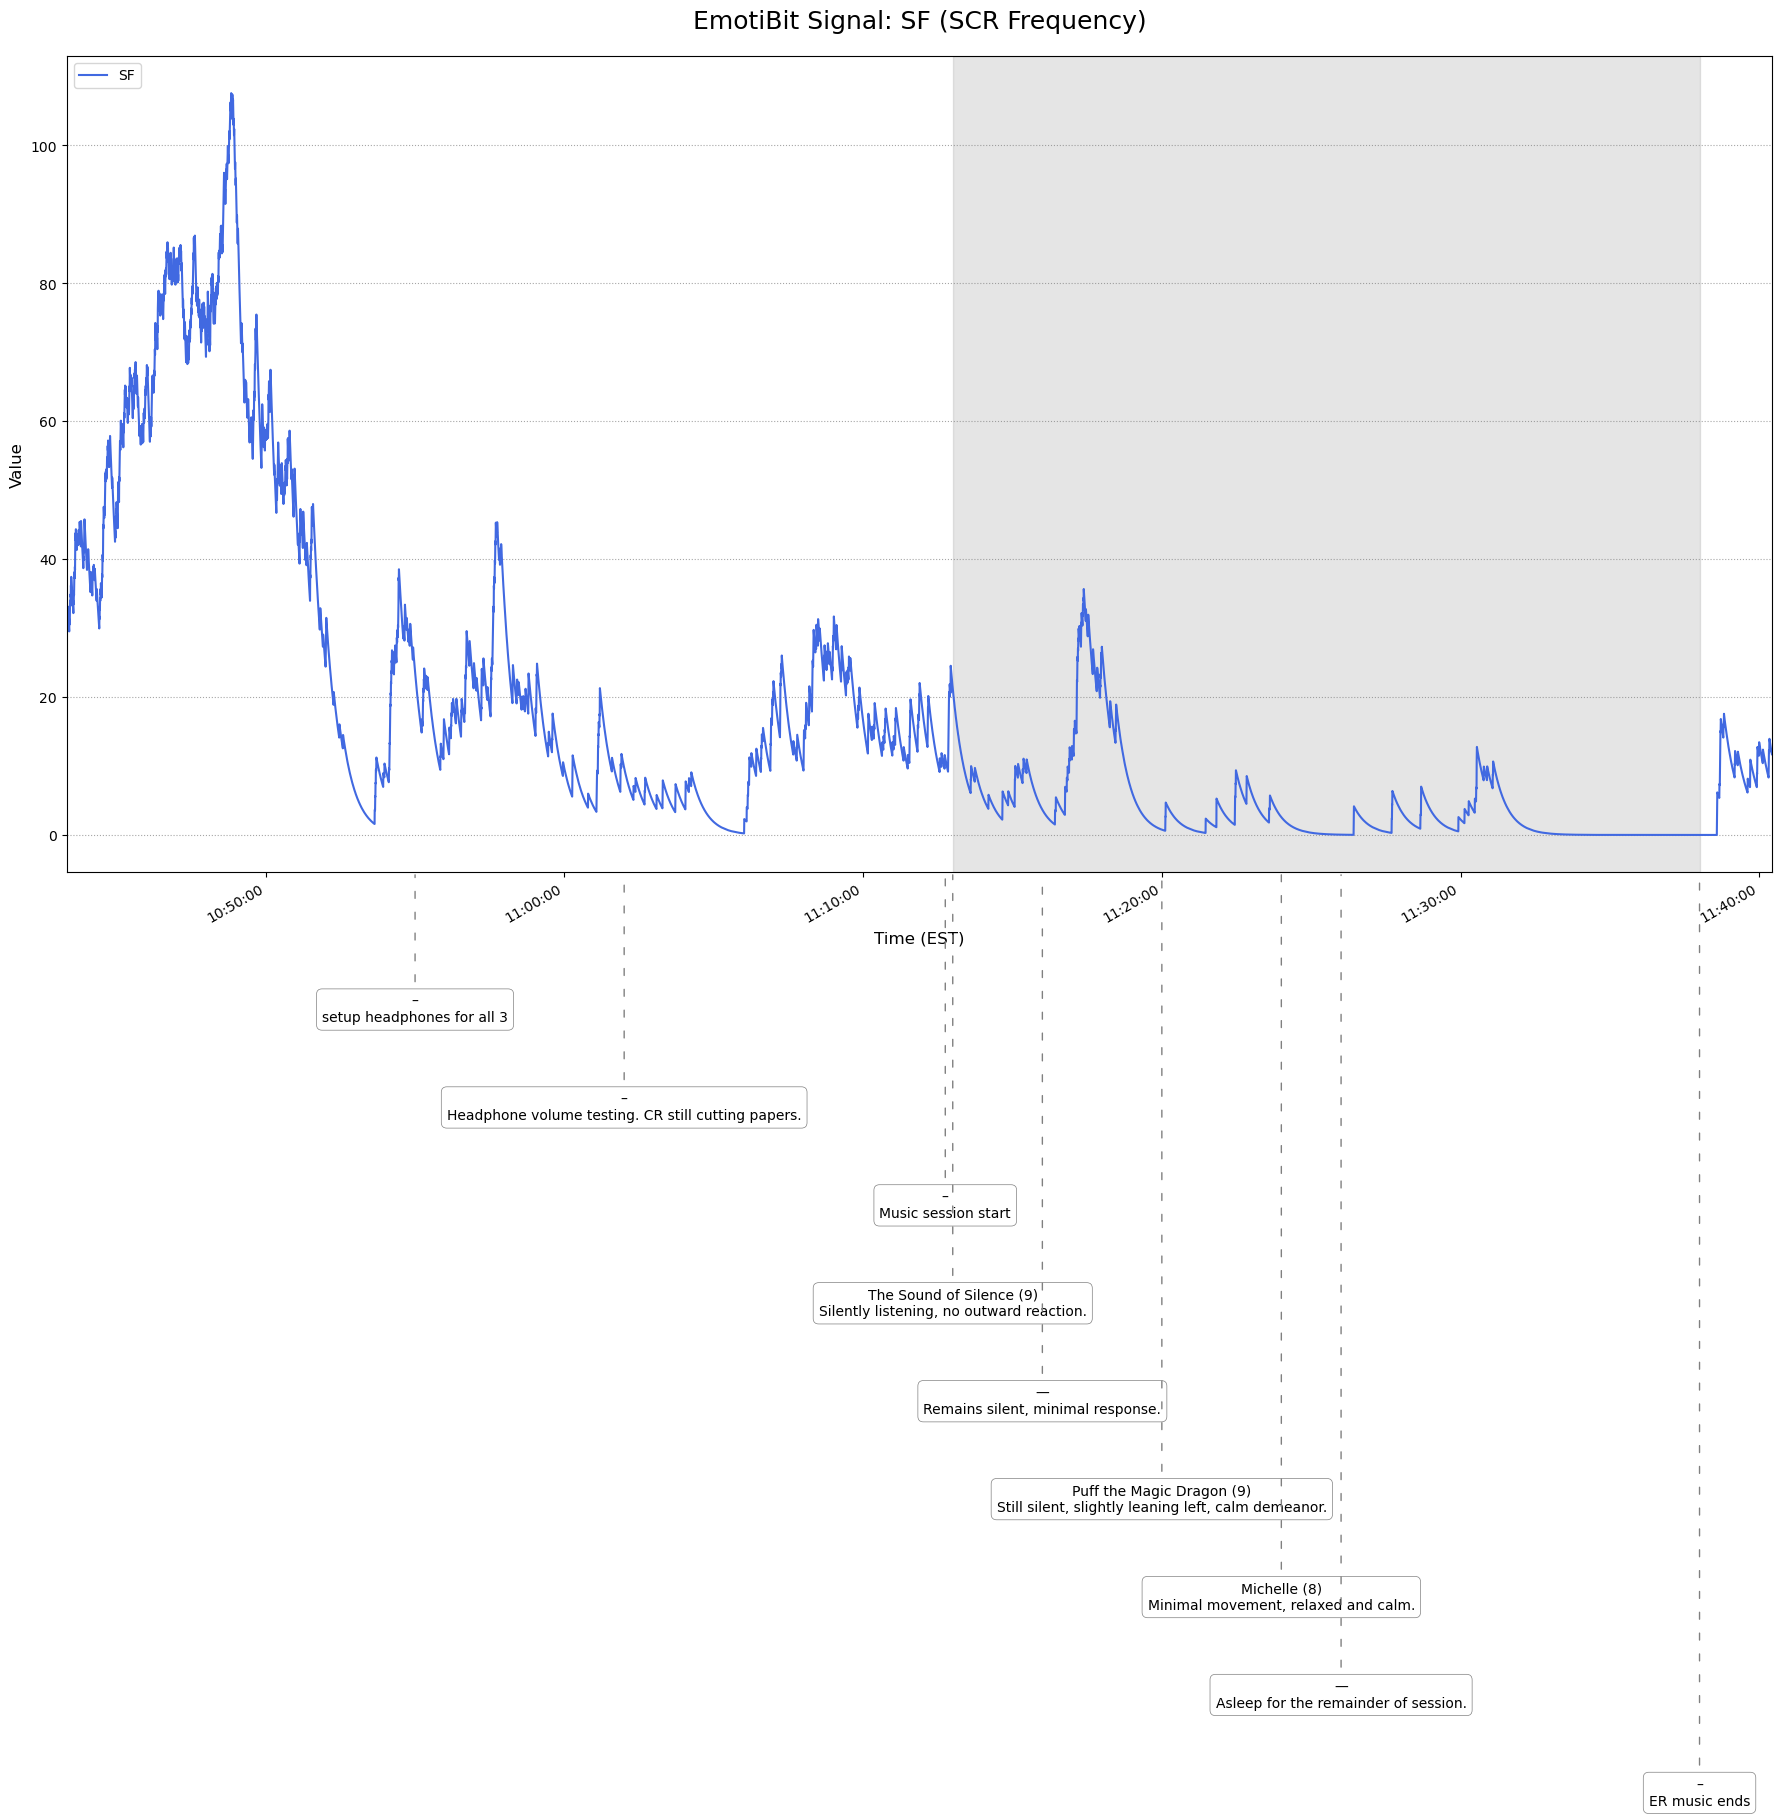

  - Plot saved to: ../PwD dataset/July 22 Morning ER 000439/plots/SF_plot.png


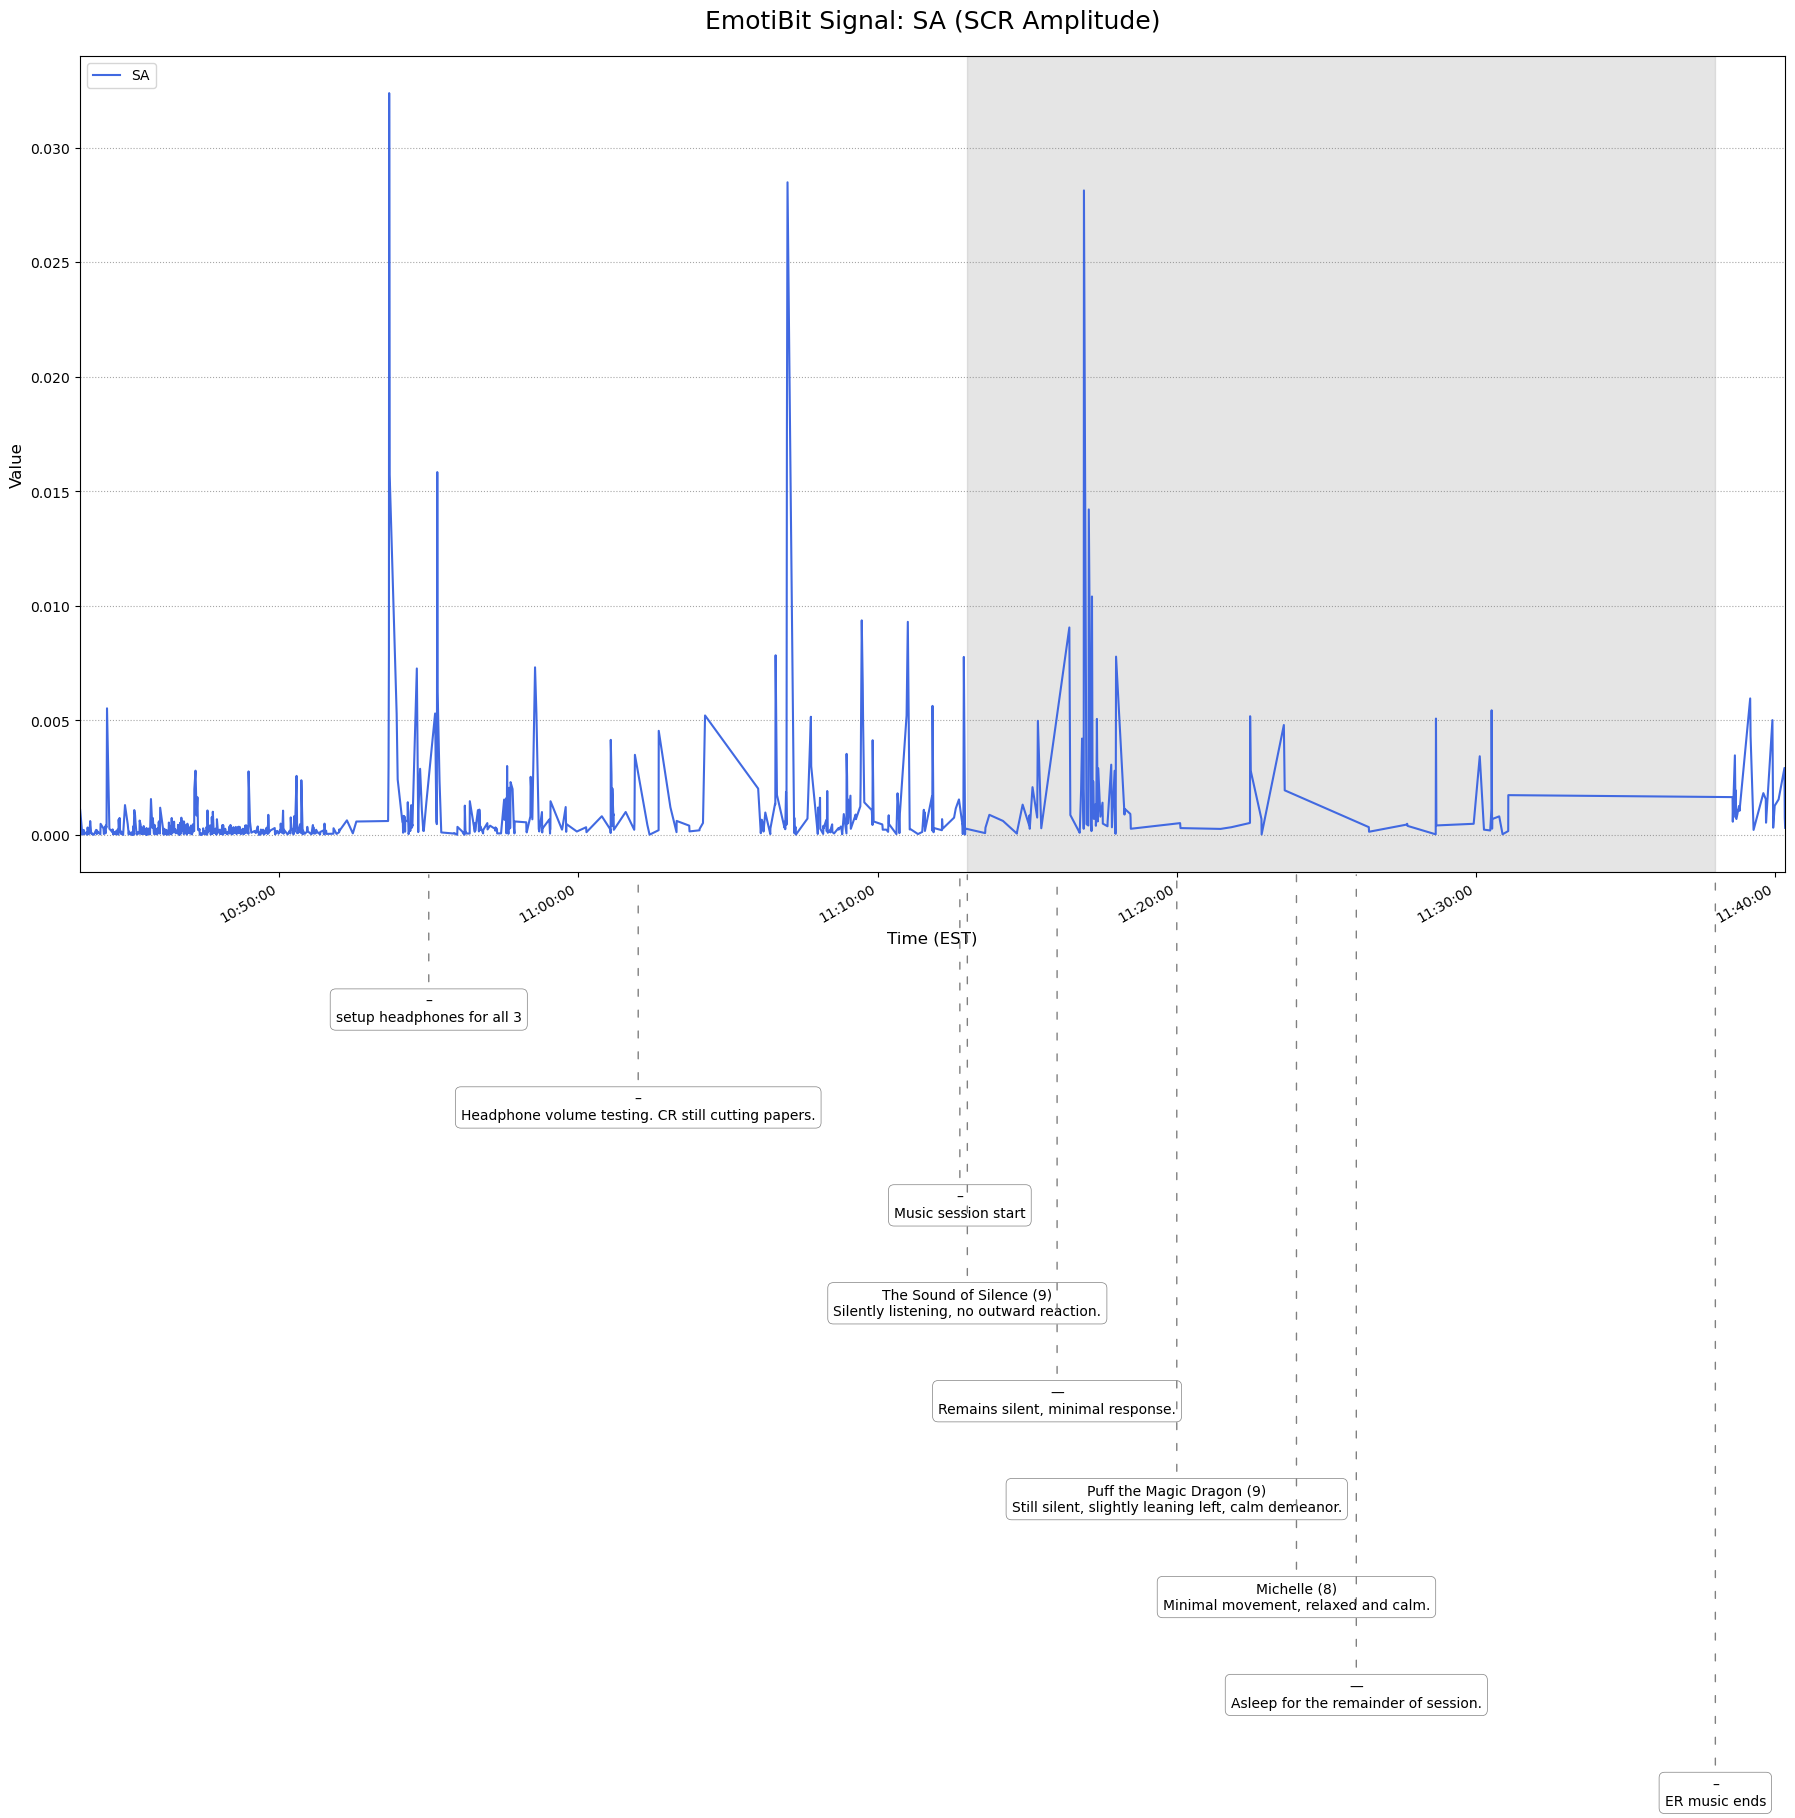

  - Plot saved to: ../PwD dataset/July 22 Morning ER 000439/plots/SA_plot.png


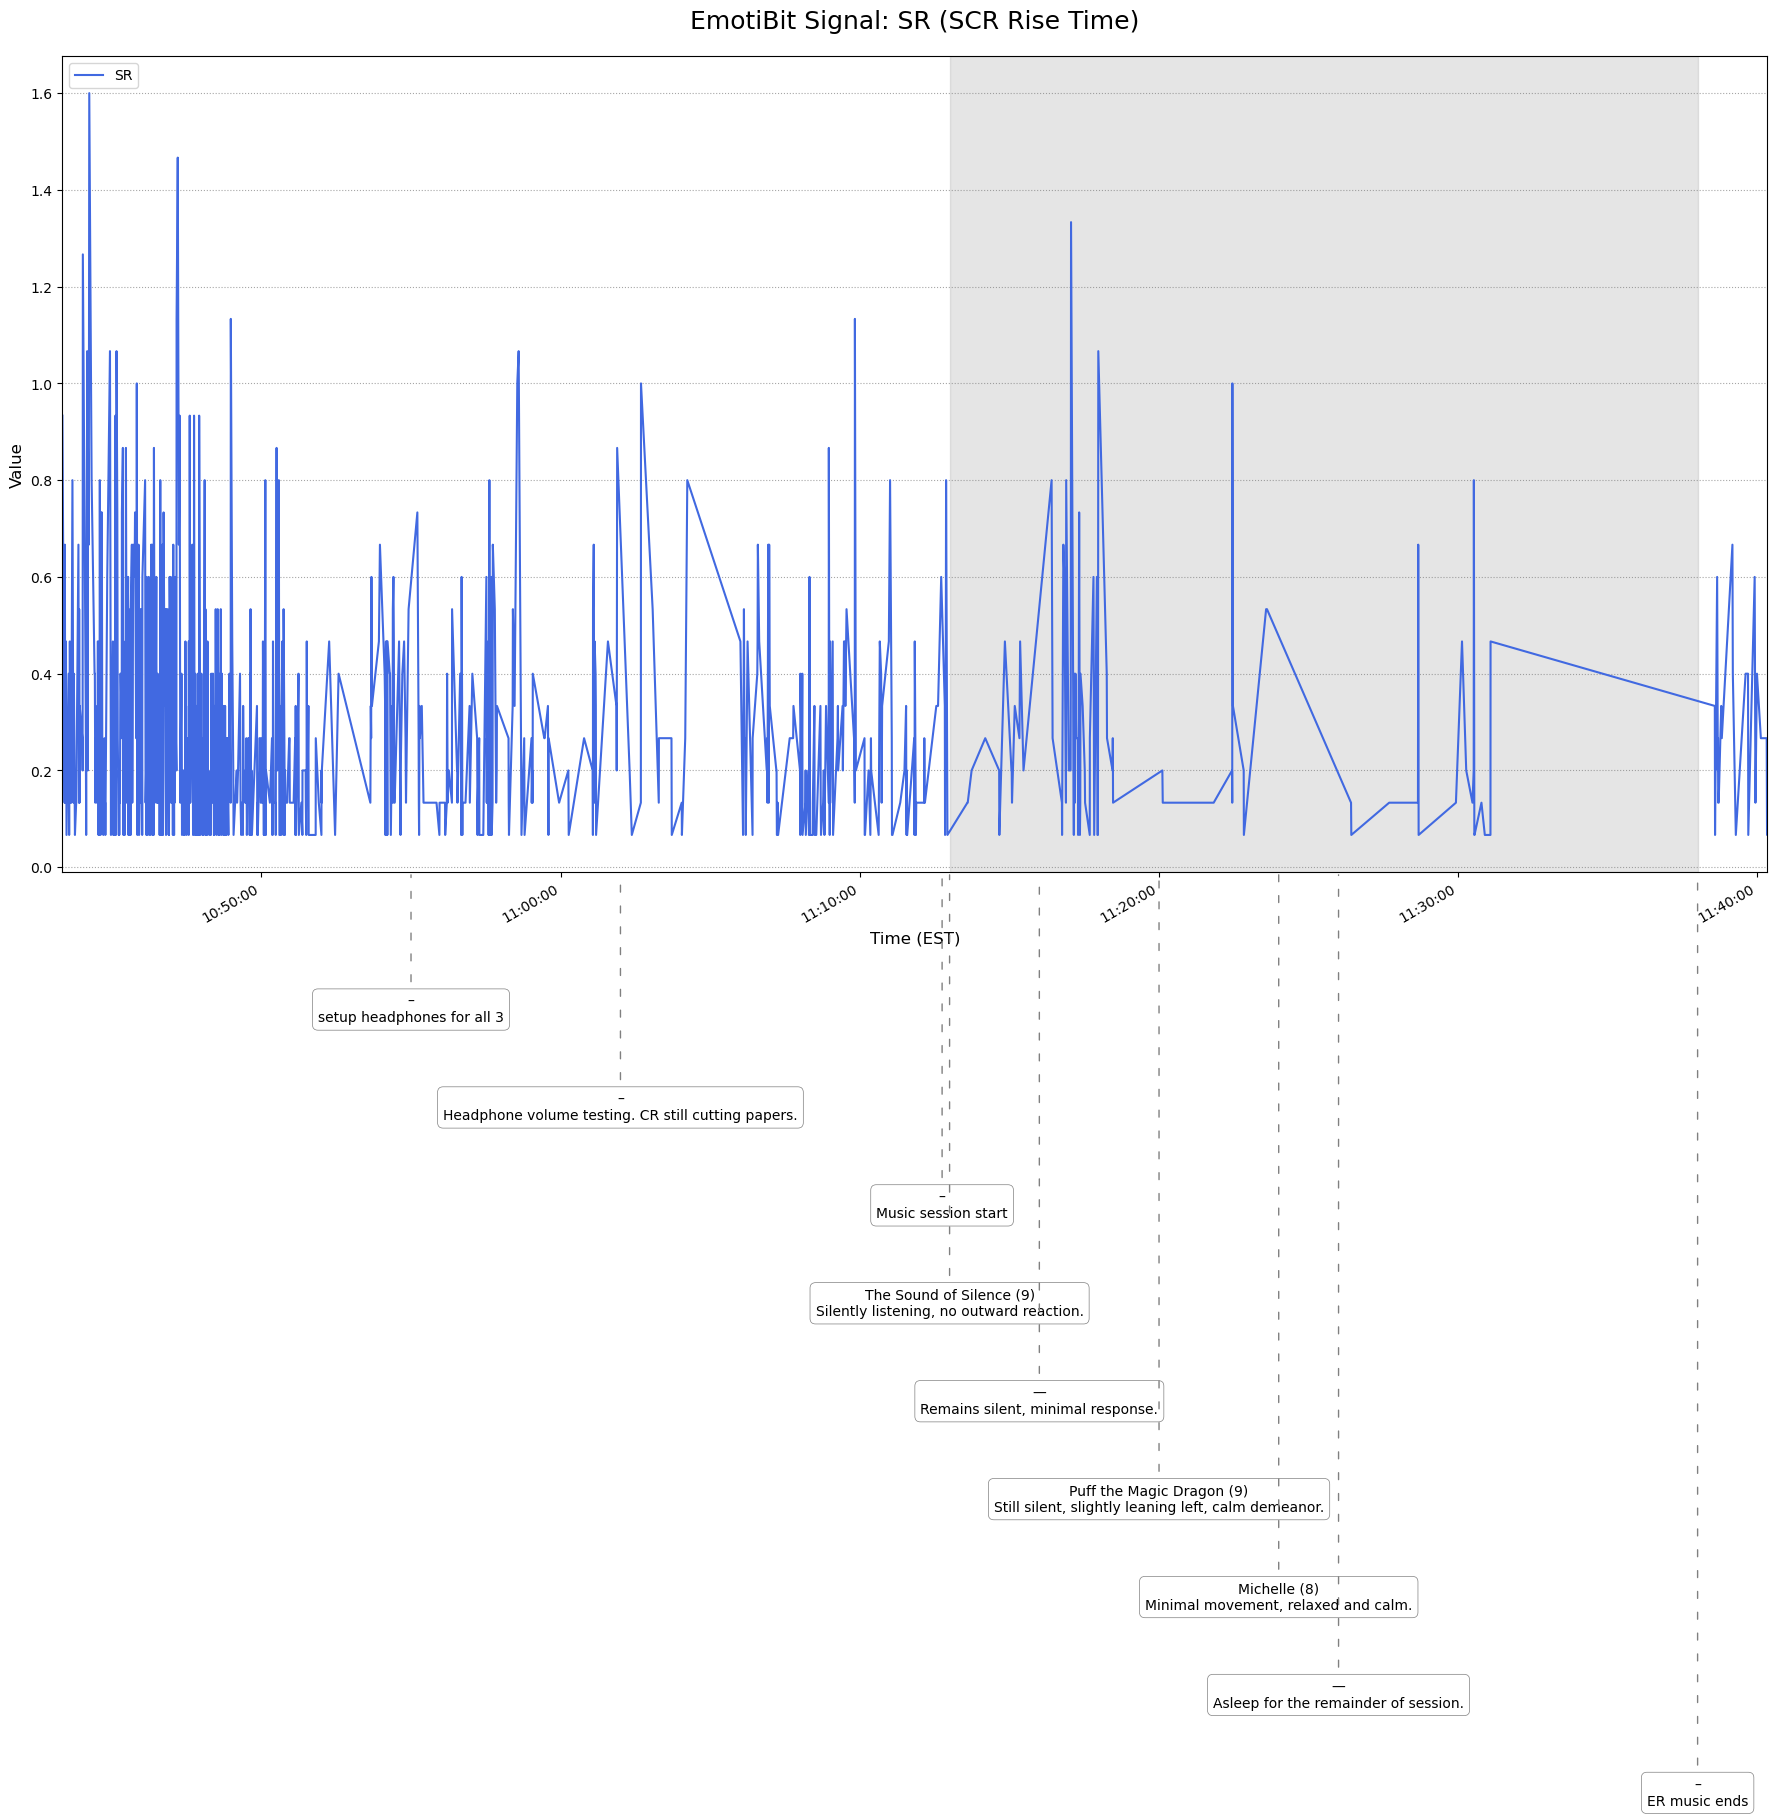

  - Plot saved to: ../PwD dataset/July 22 Morning ER 000439/plots/SR_plot.png


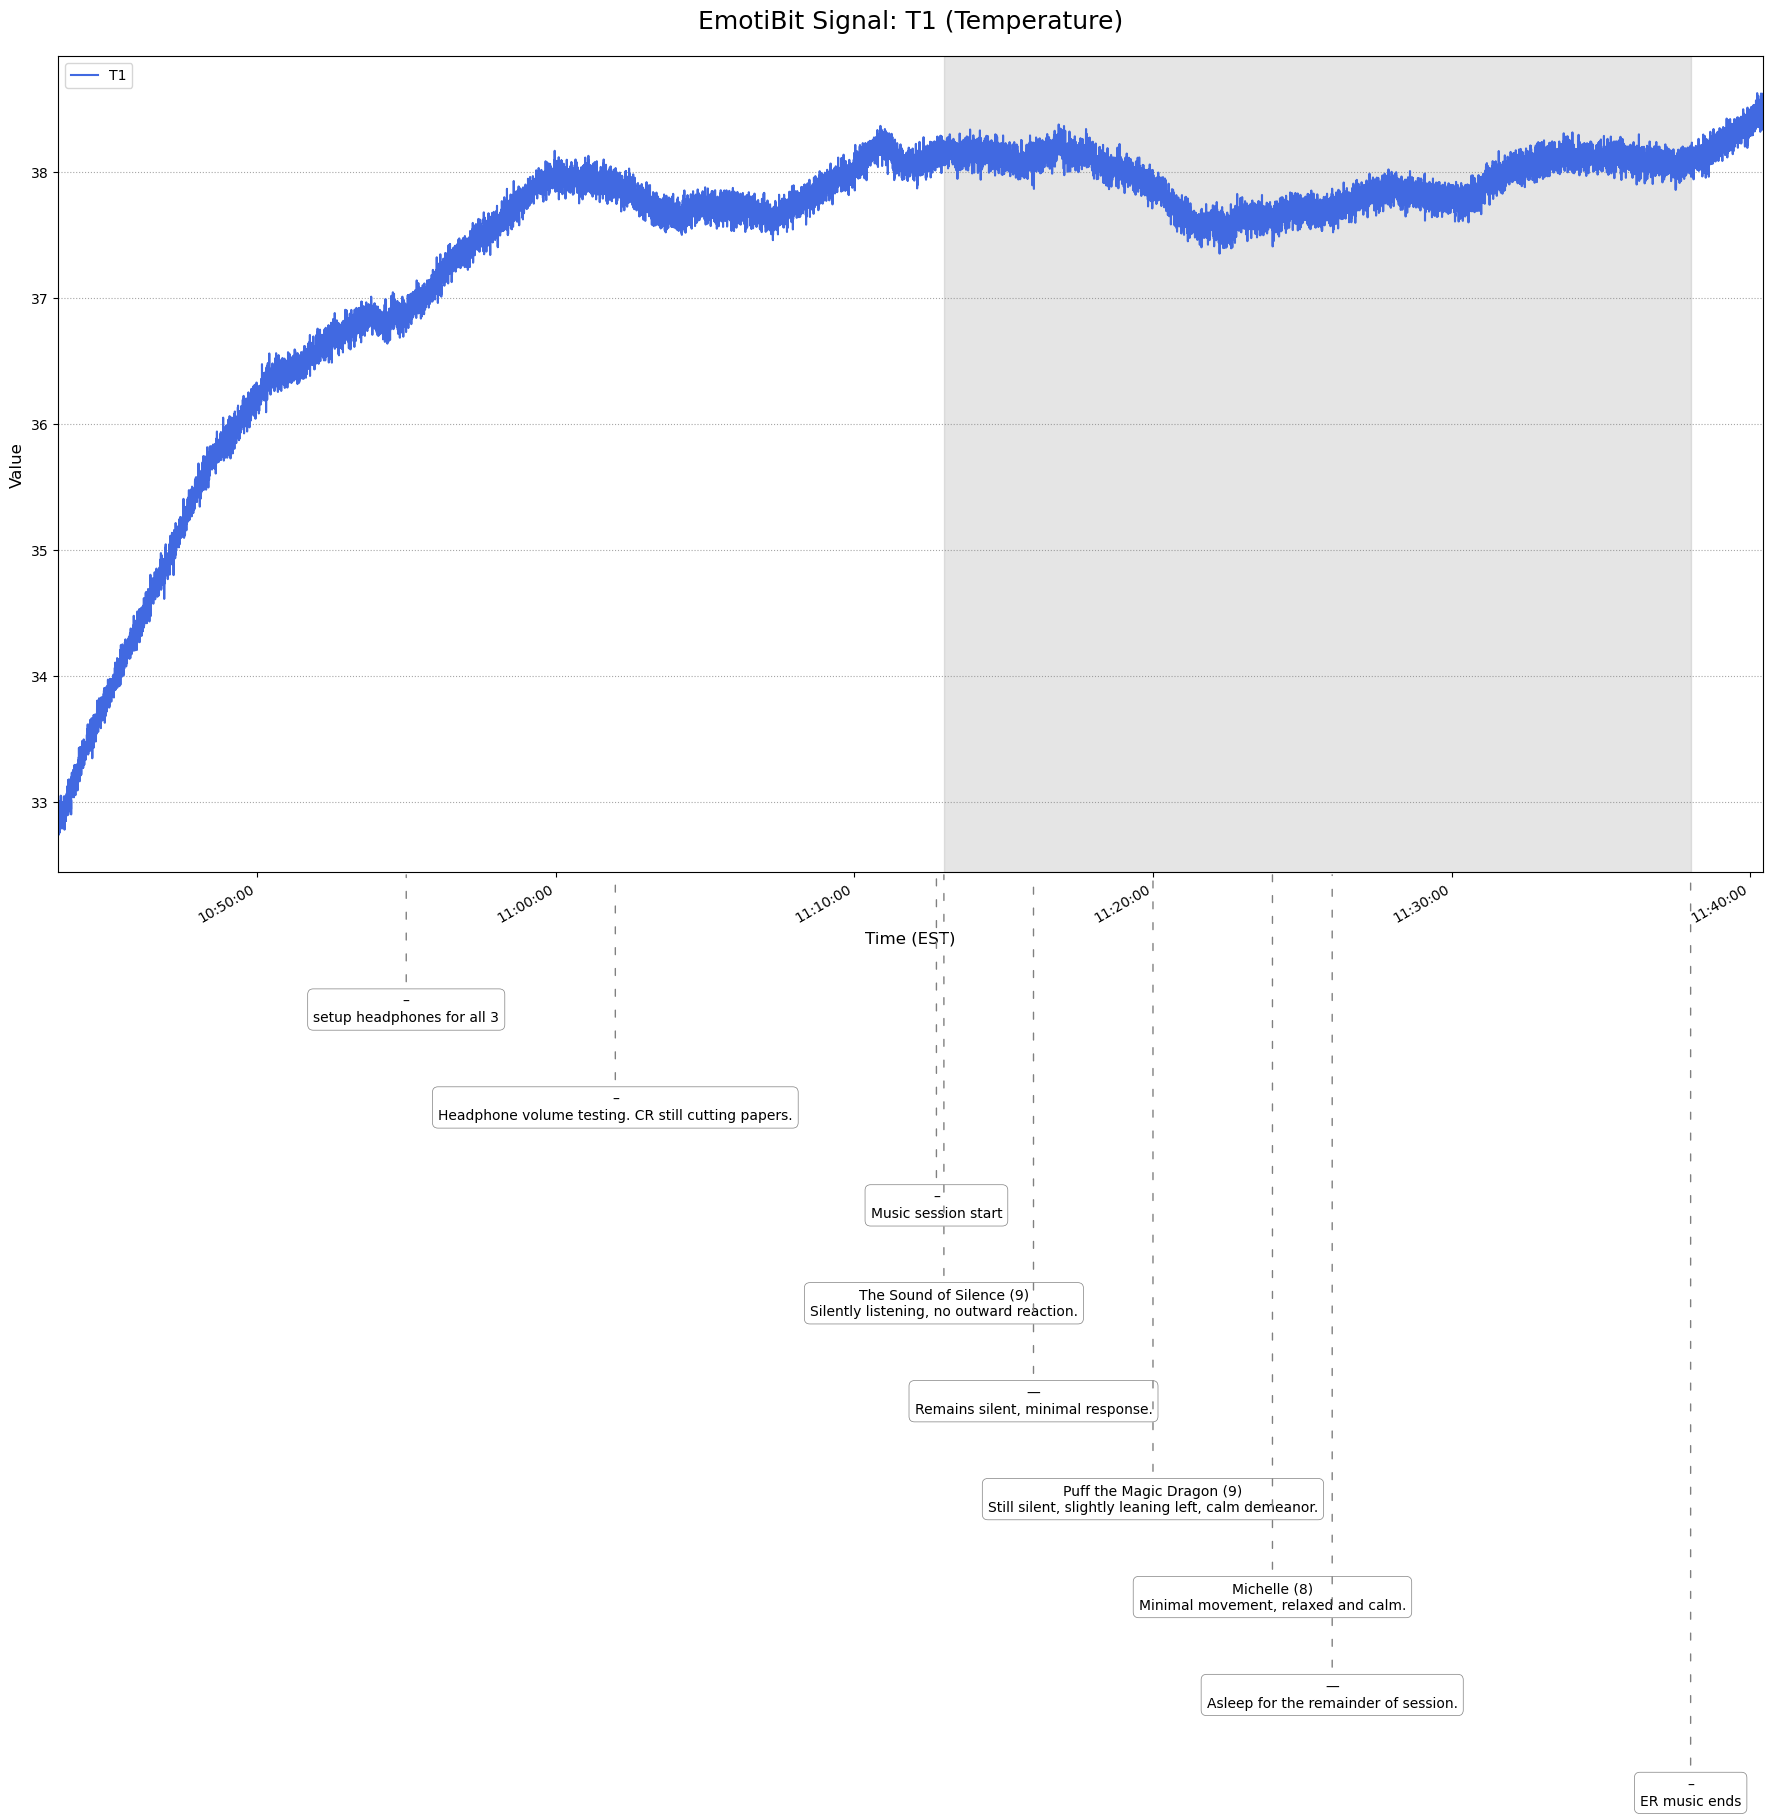

  - Plot saved to: ../PwD dataset/July 22 Morning ER 000439/plots/T1_plot.png


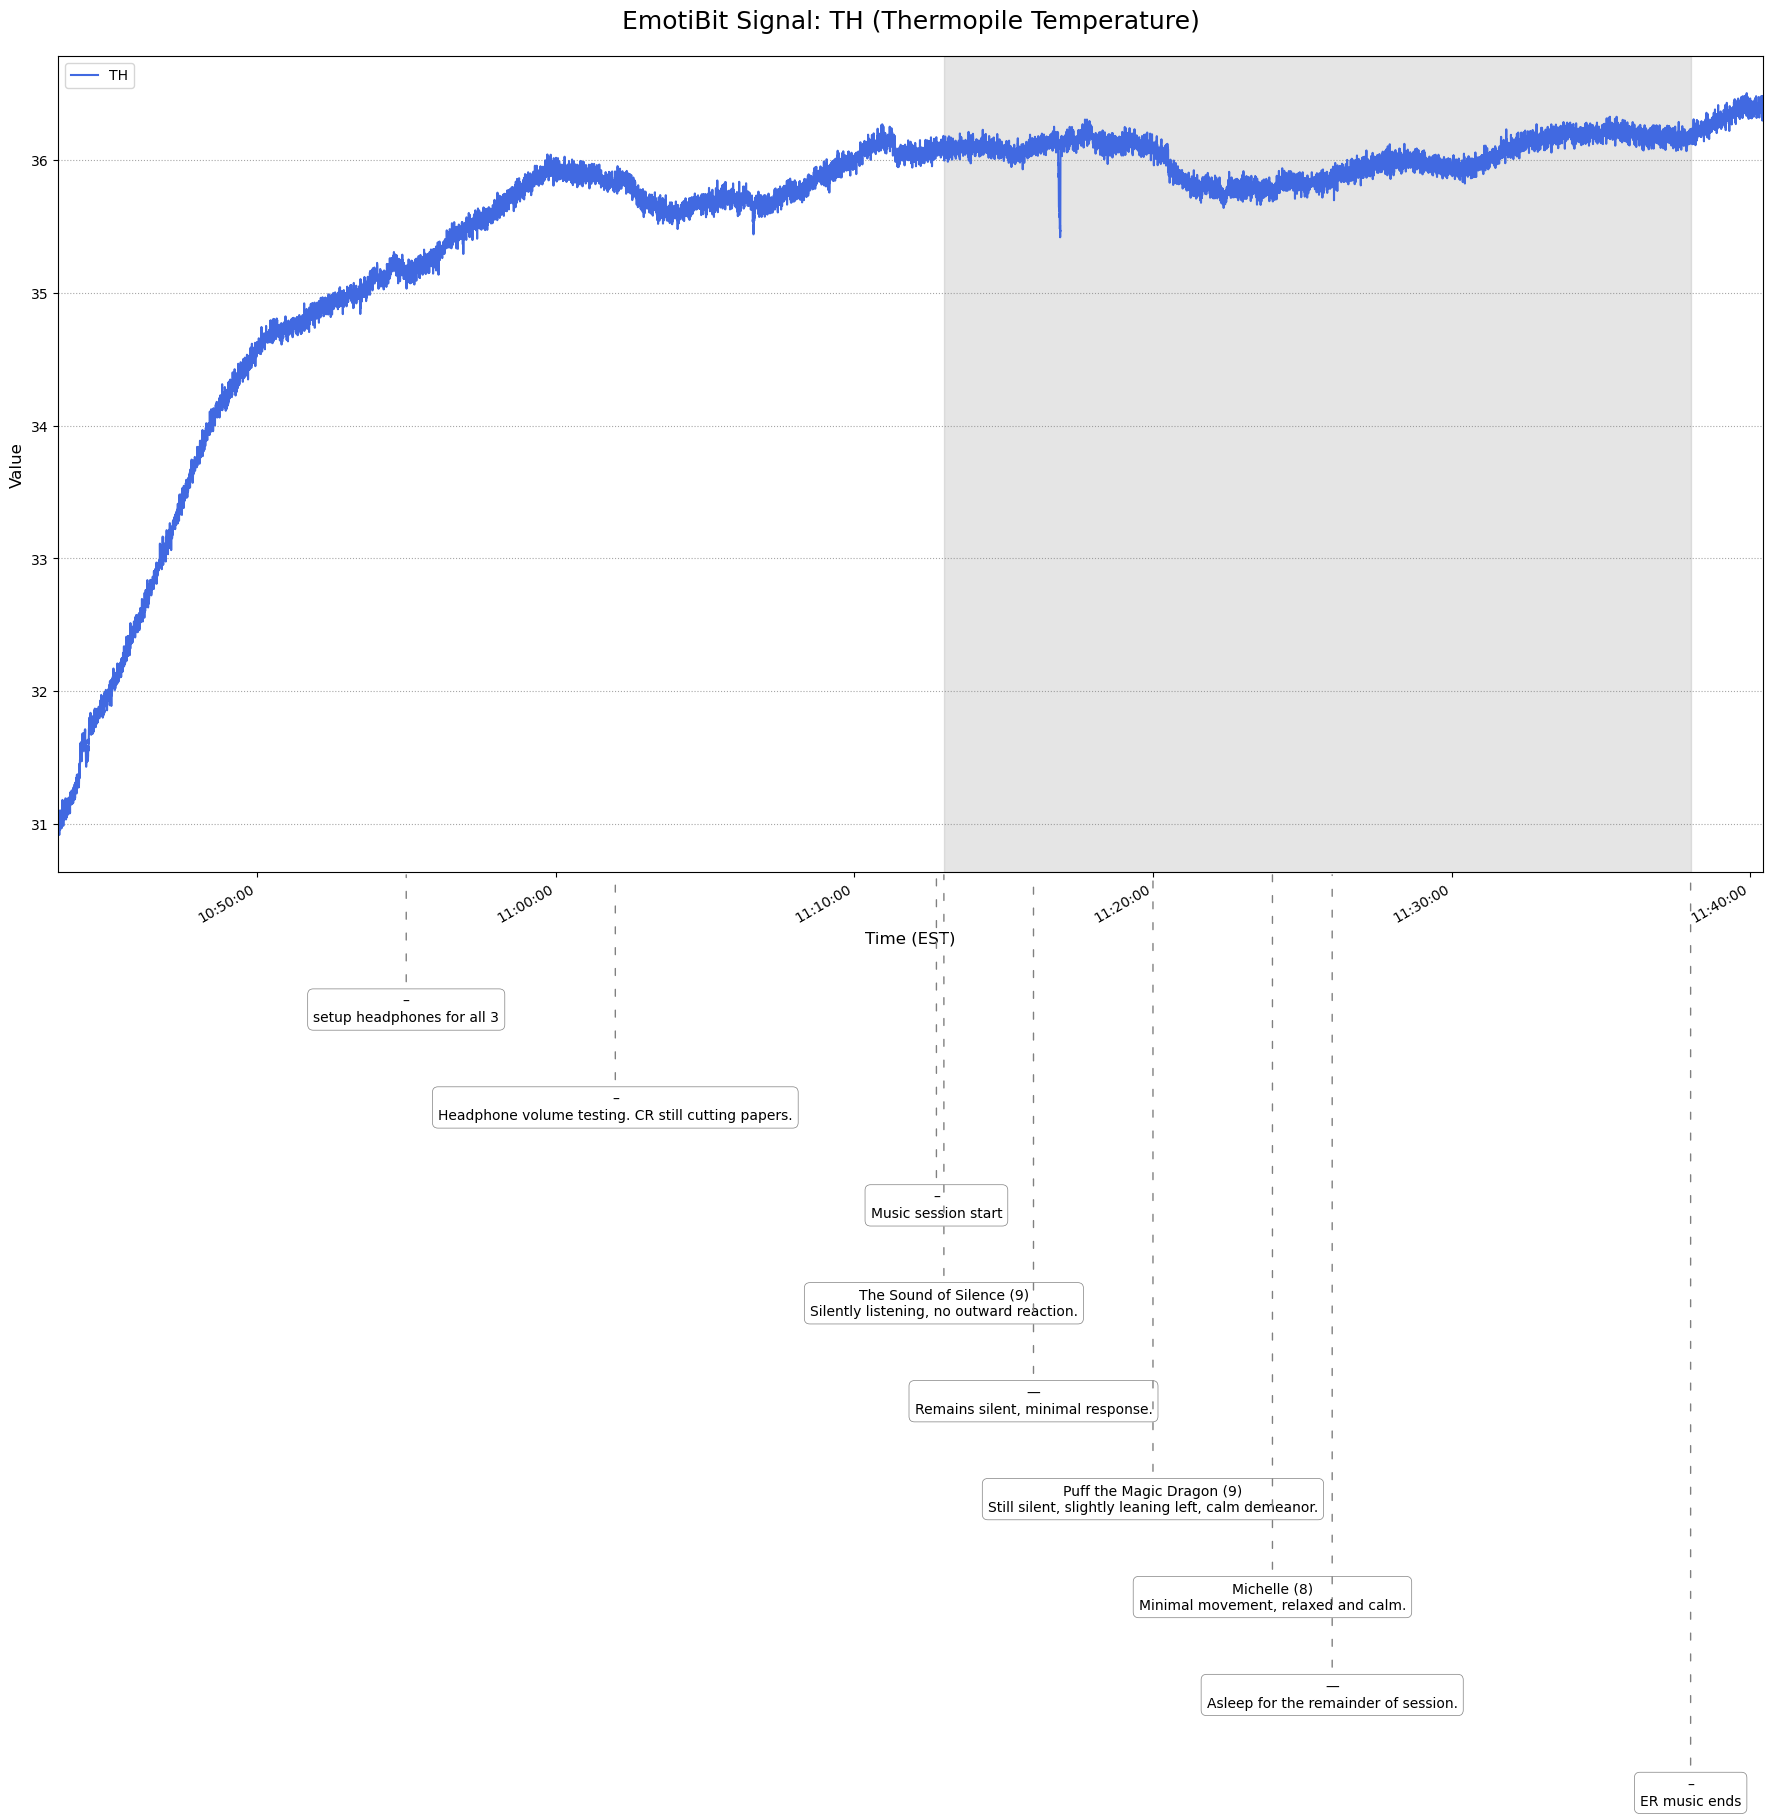

  - Plot saved to: ../PwD dataset/July 22 Morning ER 000439/plots/TH_plot.png


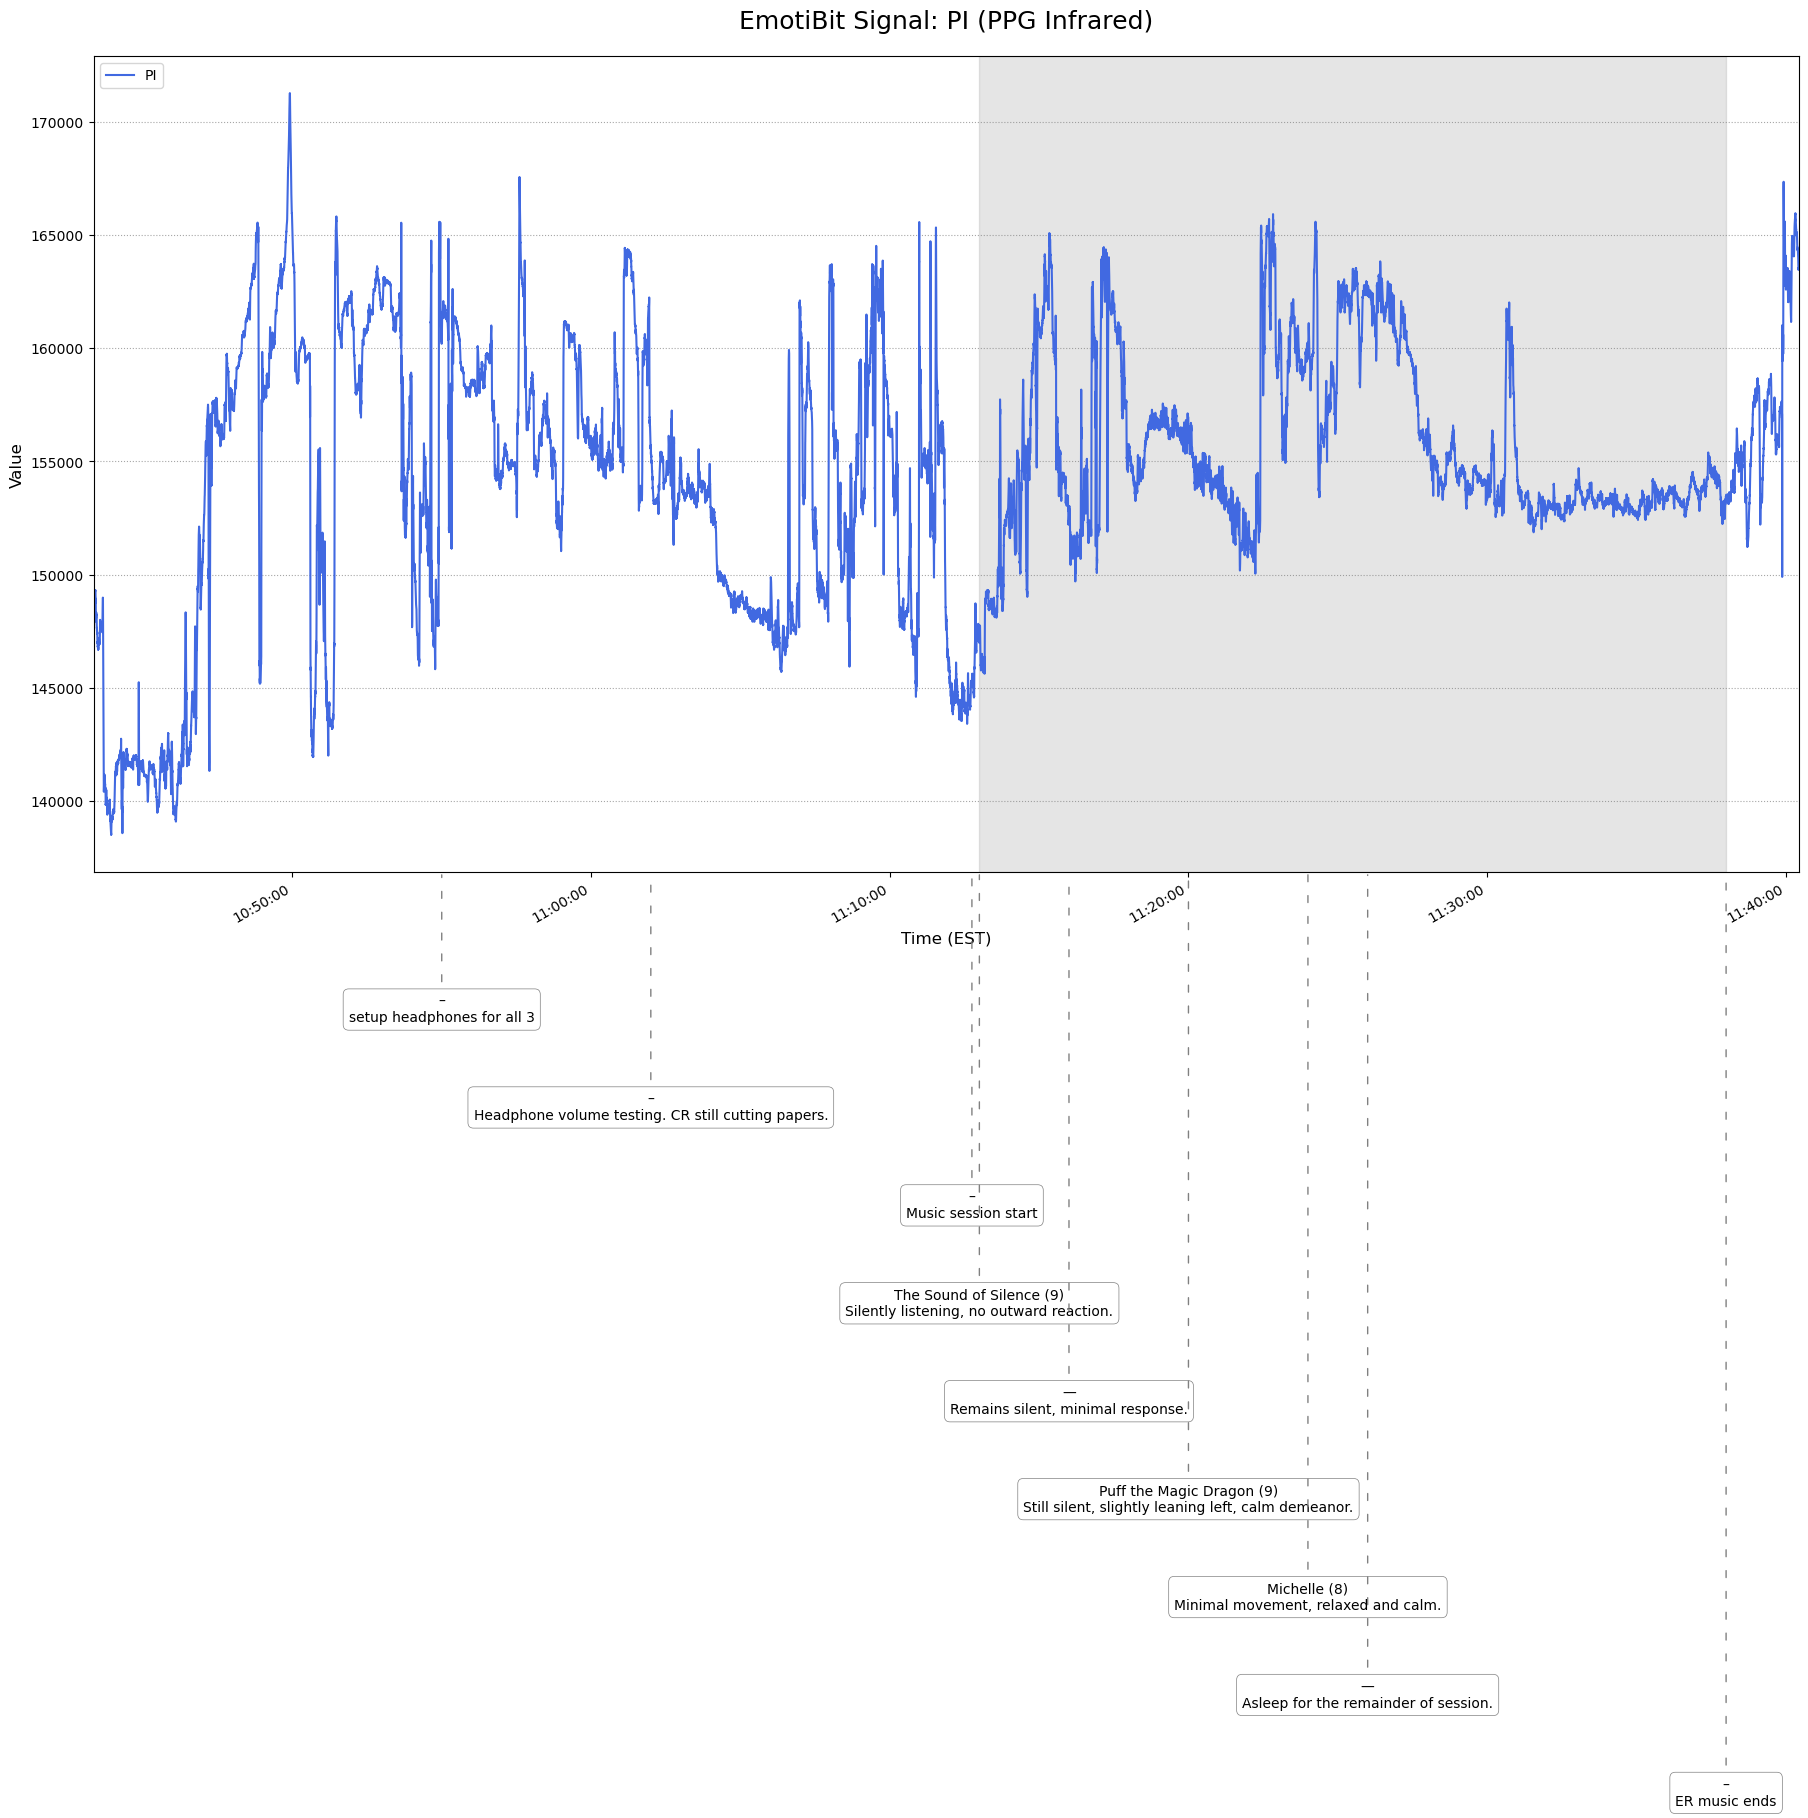

  - Plot saved to: ../PwD dataset/July 22 Morning ER 000439/plots/PI_plot.png


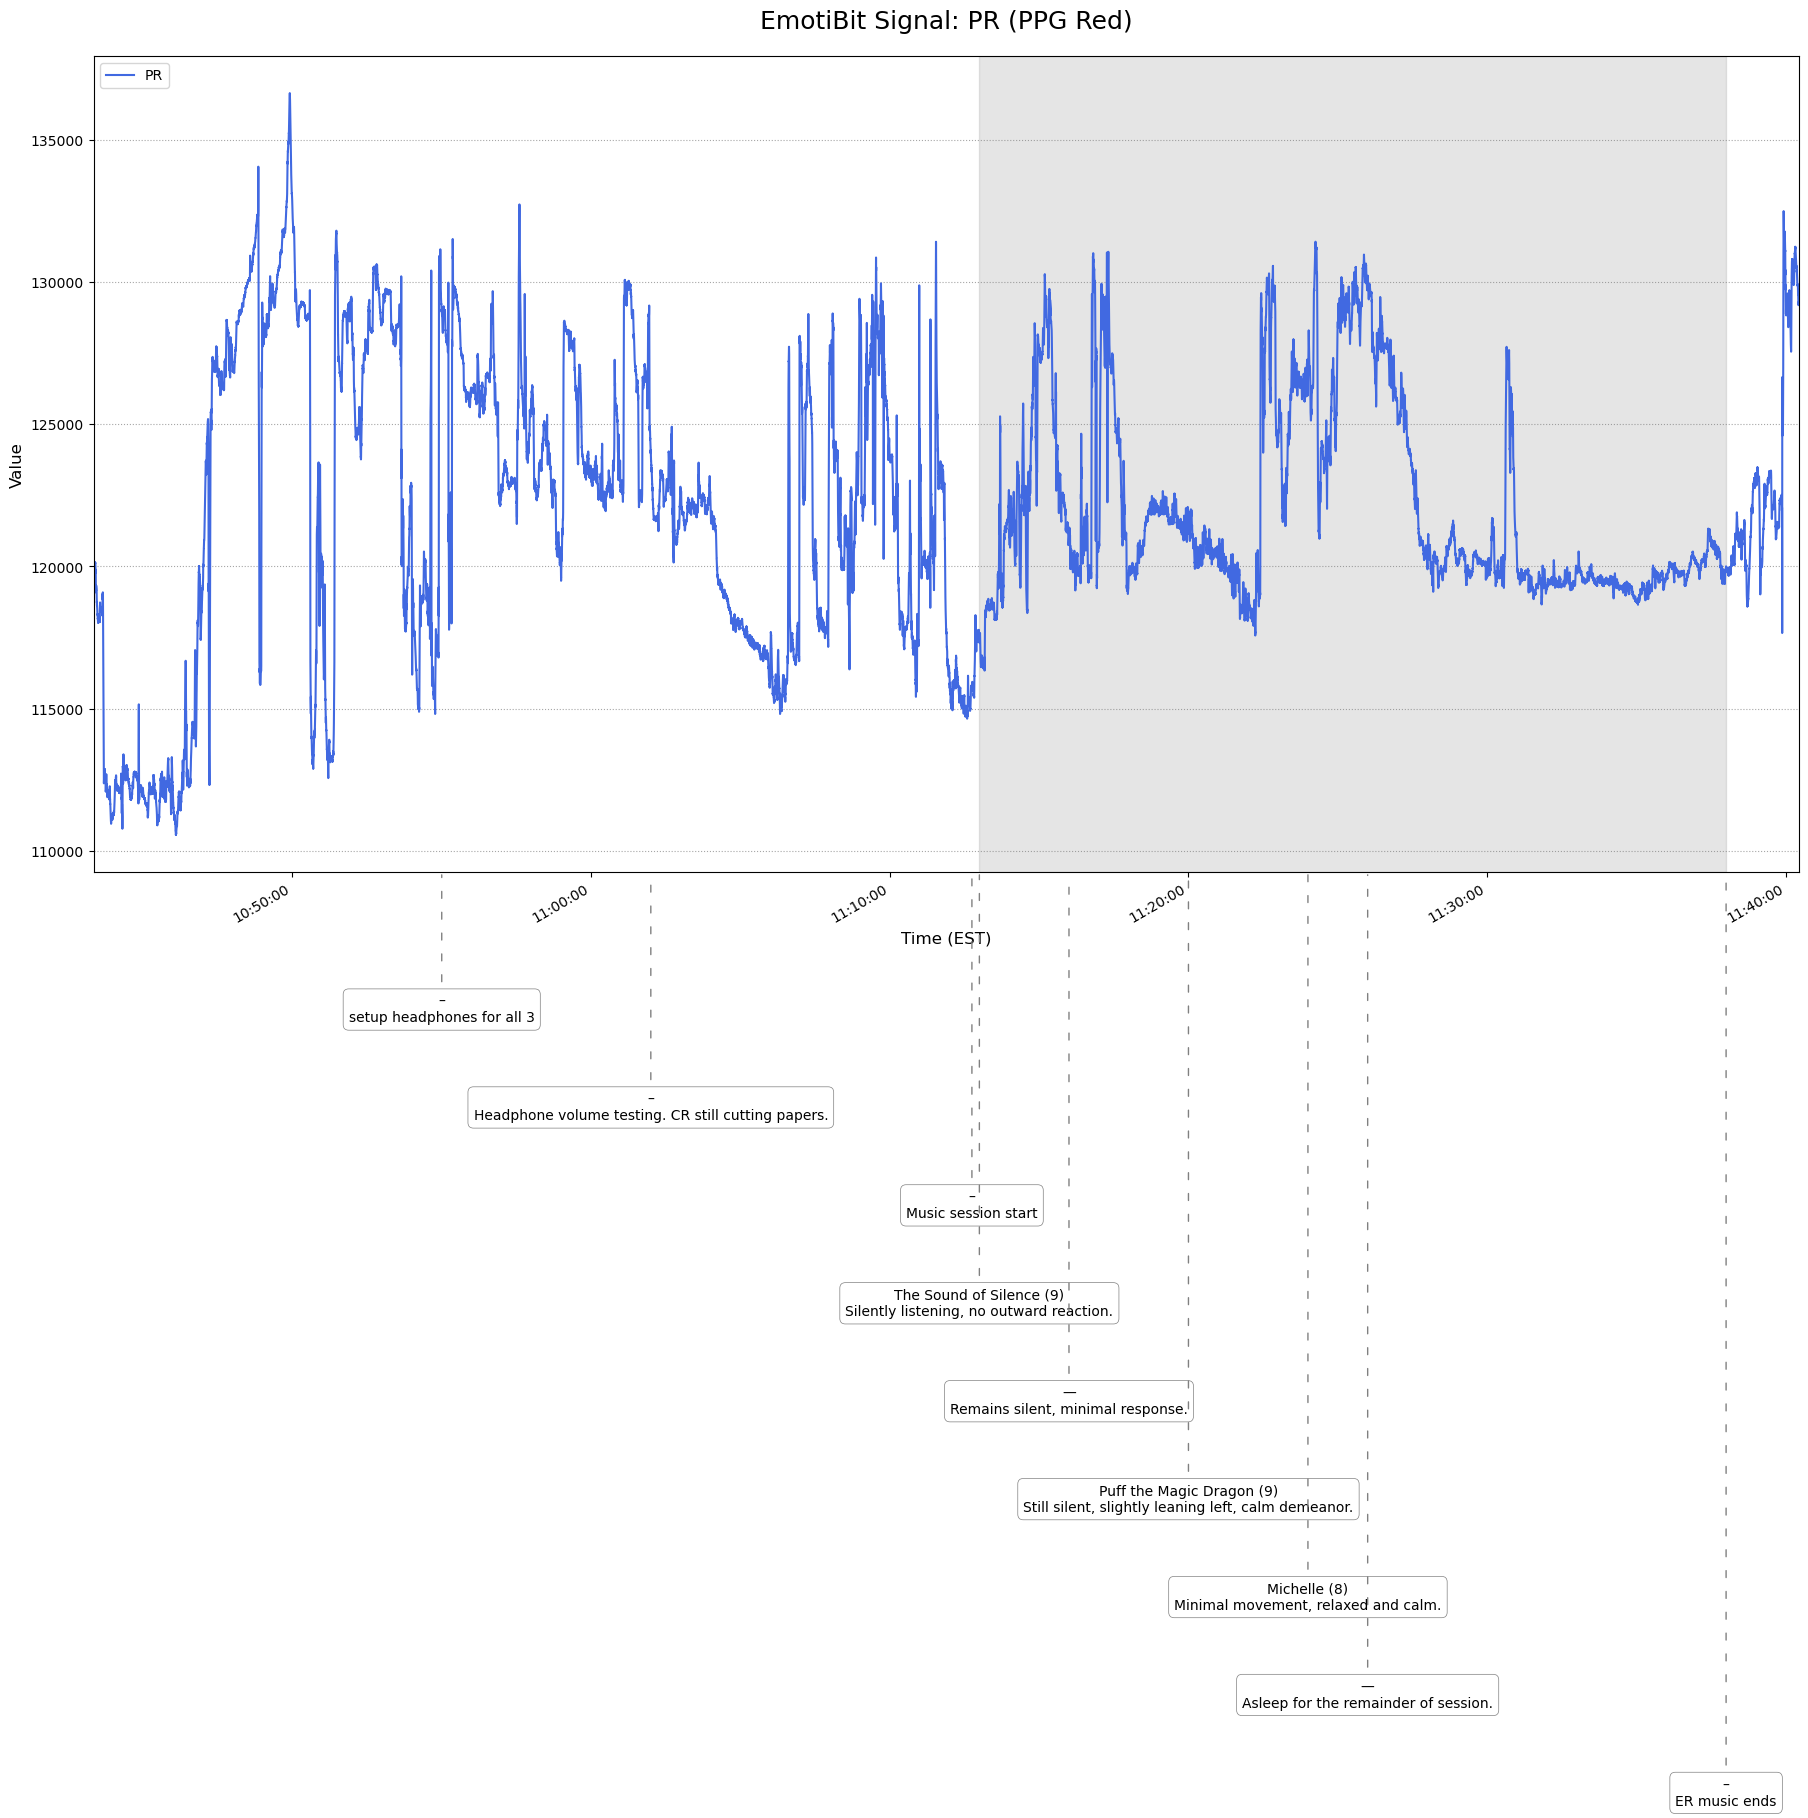

  - Plot saved to: ../PwD dataset/July 22 Morning ER 000439/plots/PR_plot.png


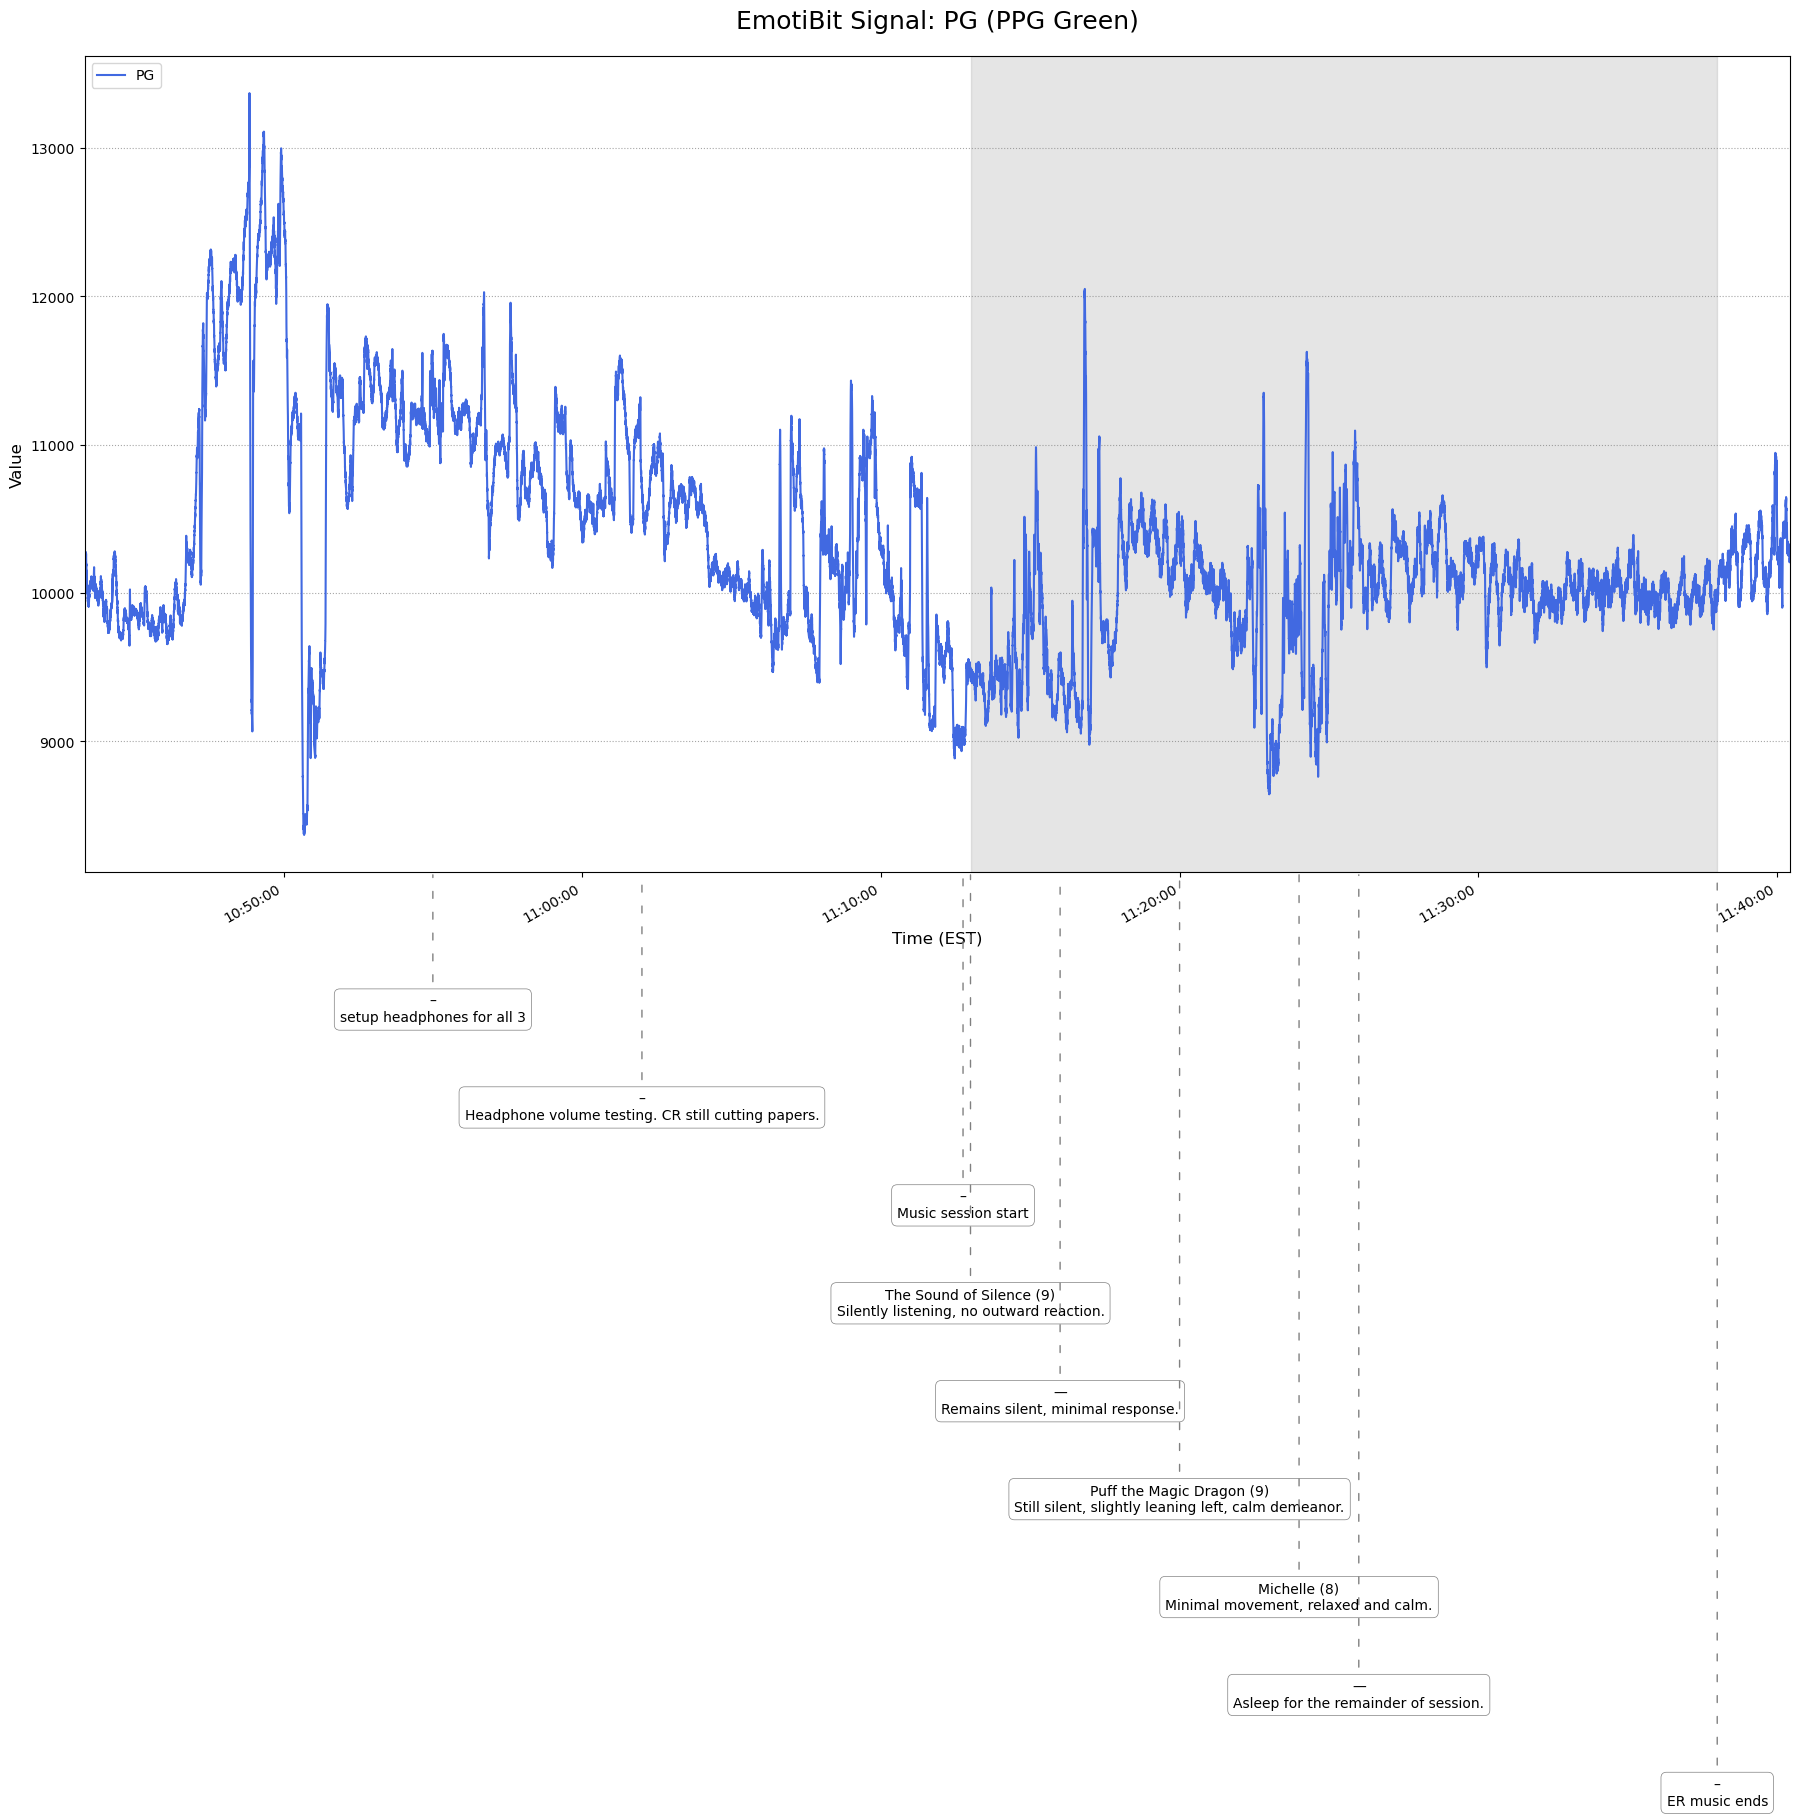

  - Plot saved to: ../PwD dataset/July 22 Morning ER 000439/plots/PG_plot.png


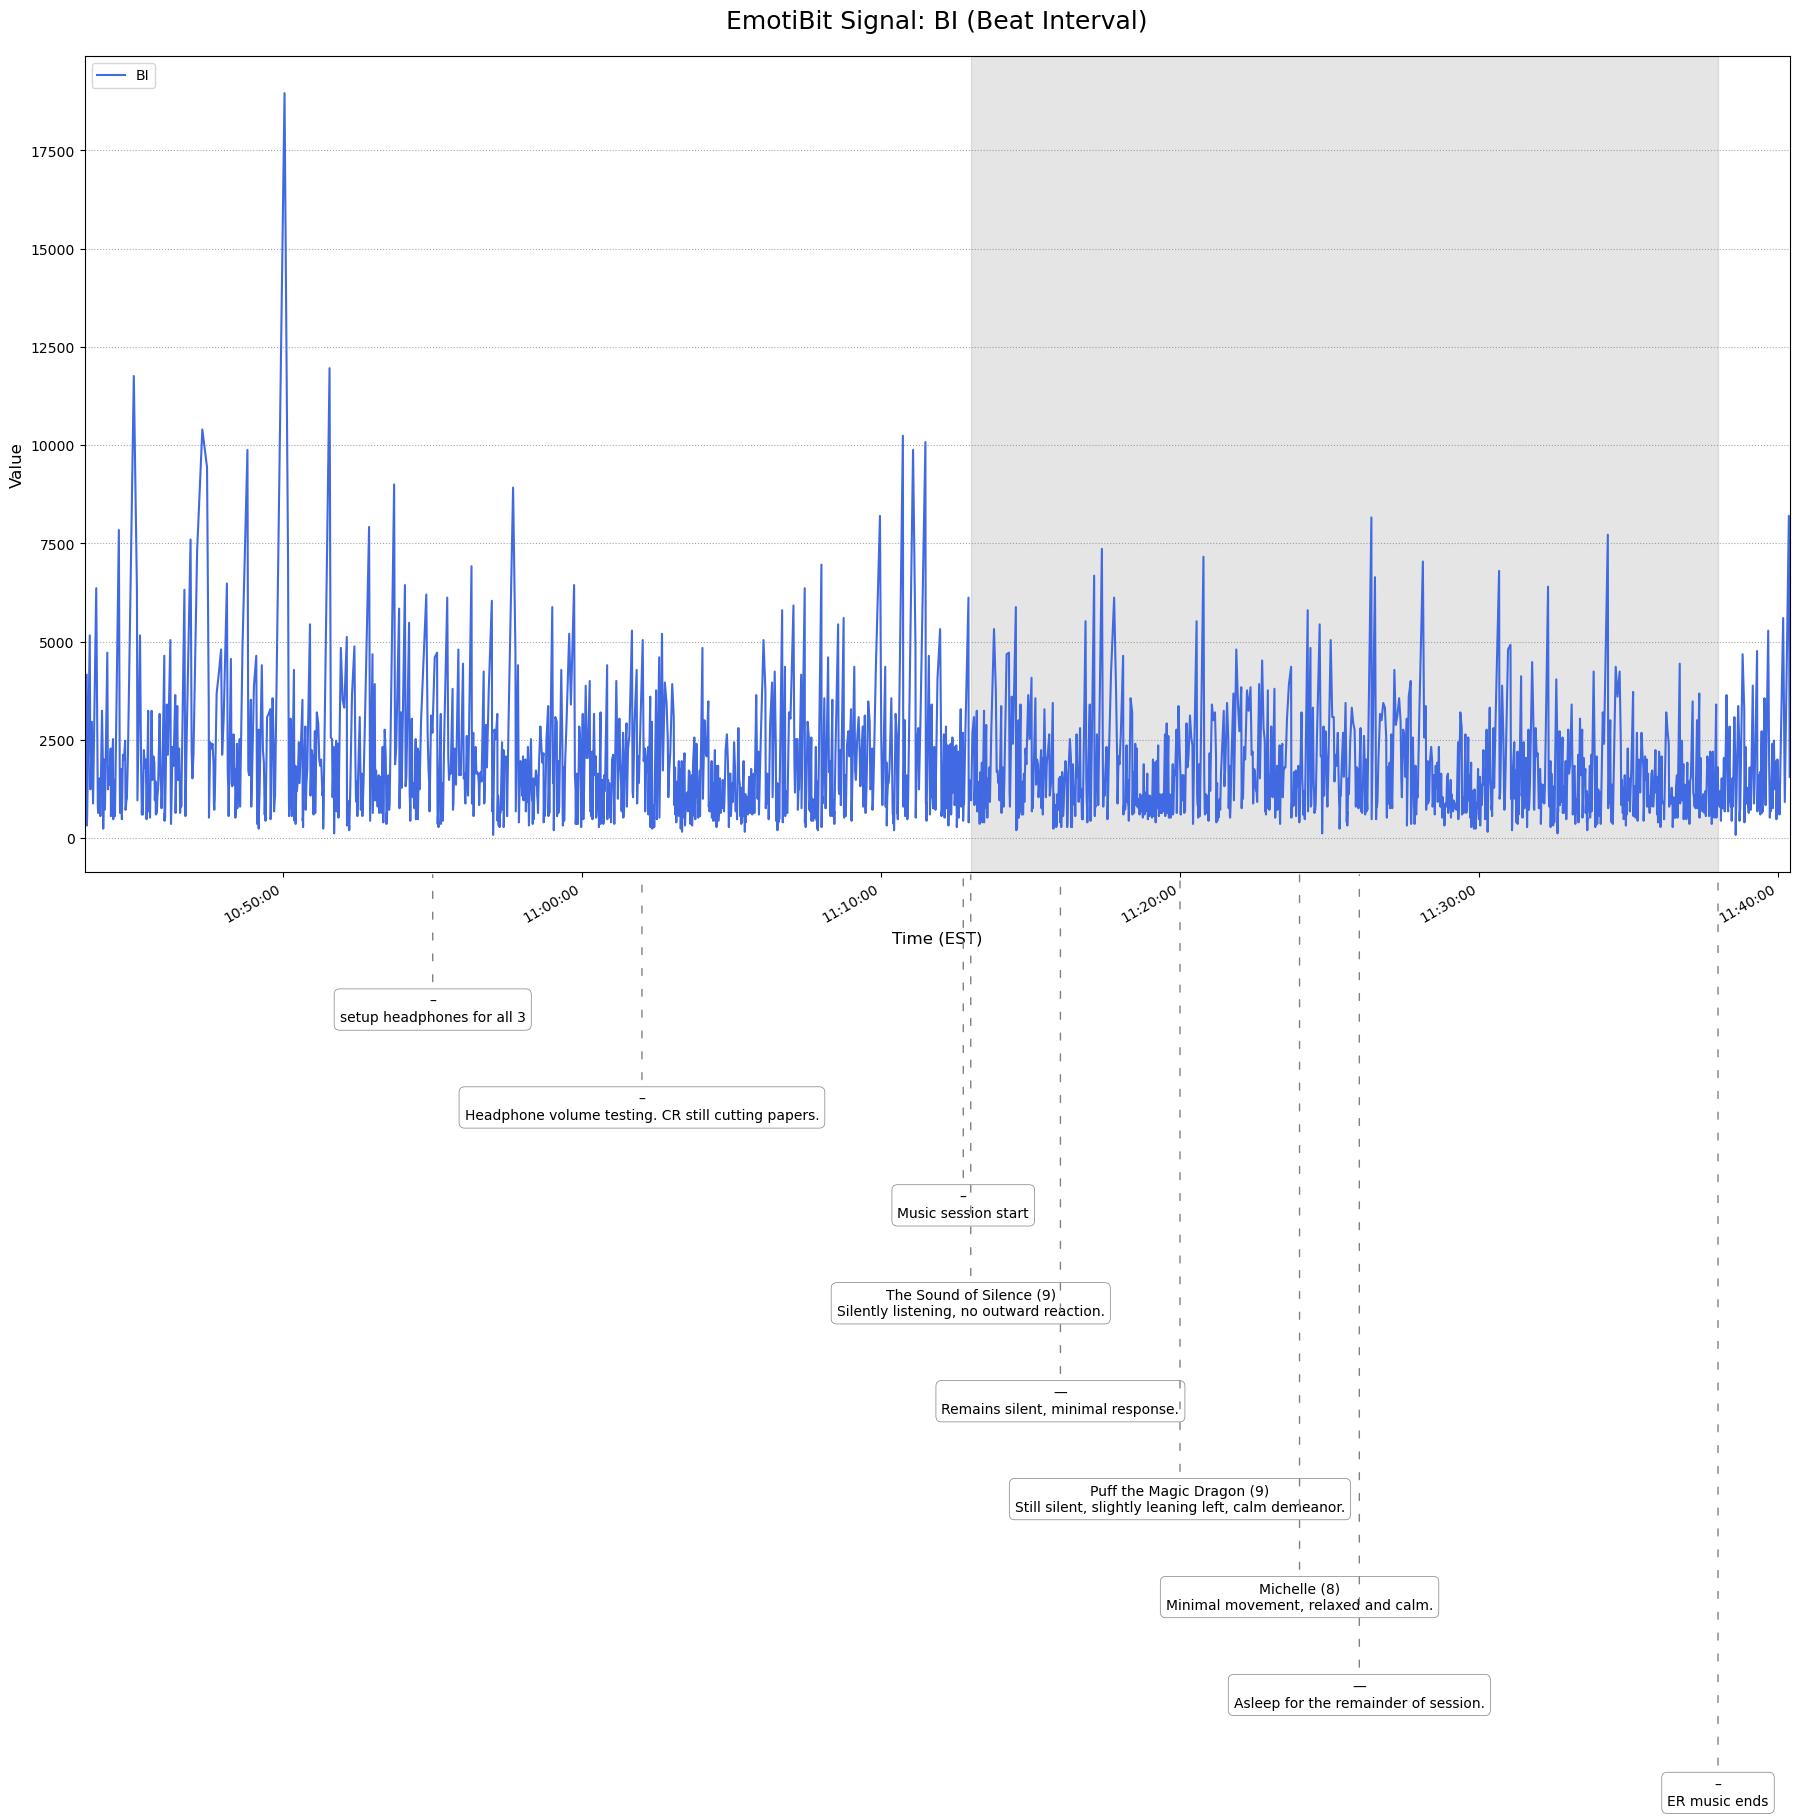

  - Plot saved to: ../PwD dataset/July 22 Morning ER 000439/plots/BI_plot.png


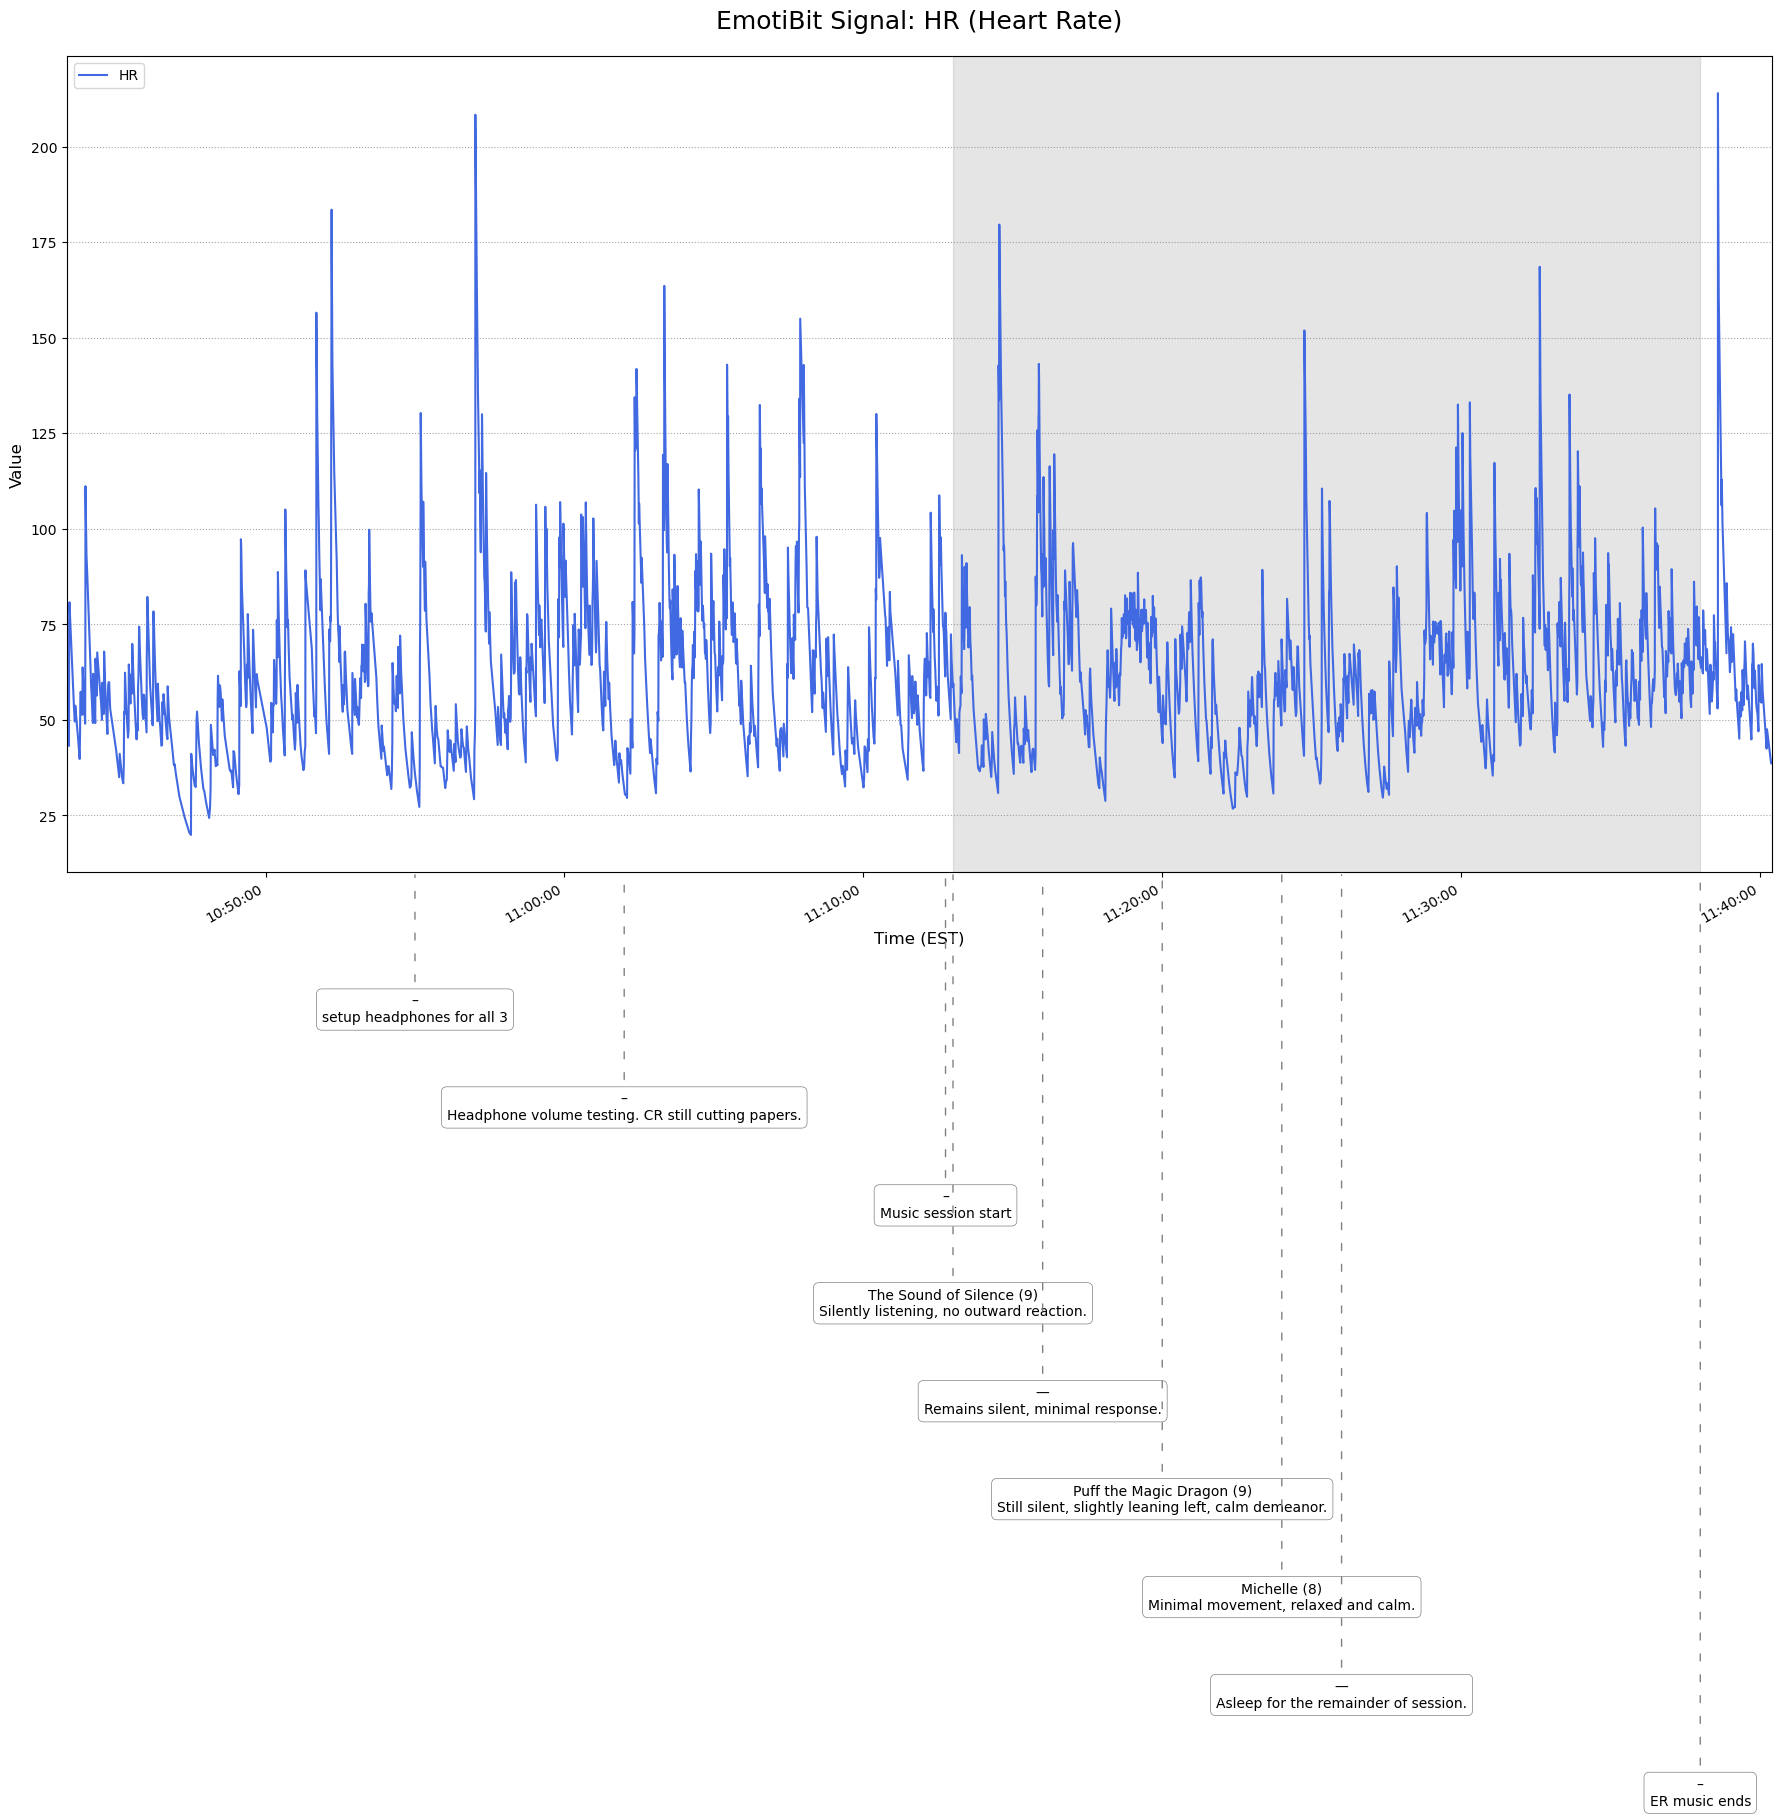

  - Plot saved to: ../PwD dataset/July 22 Morning ER 000439/plots/HR_plot.png

--- All plots have been generated and saved --- 


In [24]:
def plot_and_save_signal(signal_name, df, schedule_data, channel_map, output_folder):
    """Plots a single signal with annotations for each time point and saves the figure."""
    if df.empty or df['est_time'].isnull().all():
        return

    annotations = schedule_data.get('annotations', []) if schedule_data else []
    music_start = schedule_data.get('music_start', None) if schedule_data else None
    music_end = schedule_data.get('music_end', None) if schedule_data else None

    total_annotation_lines = sum(item['text'].count('\n') + 1 for item in annotations)
    base_height = 6
    extra_height_per_line = 0.3
    dynamic_height = base_height + (total_annotation_lines * extra_height_per_line)
    
    fig, ax = plt.subplots(figsize=(FIGURE_SIZE[0], dynamic_height))
    ax.plot(df['est_time'], df['value'], label=signal_name, color='royalblue', linewidth=1.5)
    min_time_data, max_time_data = df['est_time'].min(), df['est_time'].max()
    ax.set_xlim(min_time_data, max_time_data)
    
    if music_start and music_end:
        ax.axvspan(music_start, music_end, color=ANNOTATION_BACKGROUND_COLOR, alpha=ANNOTATION_ALPHA, zorder=0)
    
    stagger_level = 0
    y_level_start, y_level_step = -0.15, -0.08
    for annotation in annotations:
        time_point = annotation['time']
        annotation_text = annotation['text']
        
        if not (min_time_data <= time_point <= max_time_data):
            continue
        
        y_level_for_text = y_level_start + (stagger_level * y_level_step)
        
        ax.annotate(
            annotation_text, xy=(time_point, 0), xycoords=('data', 'axes fraction'),
            xytext=(time_point, y_level_for_text), textcoords=('data', 'axes fraction'),
            ha='center', va='top', fontsize=10,
            bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", lw=0.5, zorder=2),
            arrowprops=dict(arrowstyle="-", linestyle=(0, (5, 10)), color='gray', shrinkA=5, zorder=1)
        )
        stagger_level += 1

    full_signal_name = channel_map.get(signal_name, signal_name)
    ax.set_title(f'EmotiBit Signal: {signal_name} ({full_signal_name})', fontsize=18, pad=20)
    ax.set_xlabel('Time (EST)', fontsize=12)
    ax.set_ylabel('Value', fontsize=12)
    ax.grid(True, axis='y', which='major', linestyle=':', color='gray', linewidth=0.8, alpha=0.7)
    ax.legend(loc='upper left')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S', tz='US/Eastern'))
    fig.autofmt_xdate()

    plt.show()
    
    output_filename = f"{signal_name}_plot.png"
    full_output_path = os.path.join(output_folder, output_filename)
    fig.savefig(full_output_path, dpi=150, bbox_inches='tight', pad_inches=0.1)
    print(f"  - Plot saved to: {full_output_path}")
    plt.close(fig)

# --- Execute Plotting and Saving --- #
if not emotibit_data:
    print("Execution finished. No data was loaded, so no plots were generated.")
elif not schedule_data:
    print("Execution finished. Schedule data could not be loaded, so no plots were generated.")
else:
    print(f"\n--- Generating and Saving {len(emotibit_data)} Plots ---")
    for signal, df in emotibit_data.items():
        plot_and_save_signal(signal, df, schedule_data, CHANNELS, OUTPUT_FOLDER)
    print("\n--- All plots have been generated and saved --- ")